In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install accelerate==0.27.2 #RUN THIS THEN RESTART, RUN THE NEXT CELL, THEN SCROLL DOWN AND RUN WHERE IT SAYS TO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 7.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import json
import shutil
from PIL import Image
import requests
import cv2
from torch.utils.data import Dataset, DataLoader

In [ ]:
len(os.listdir("/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/Train_Vids"))

10242

**Data Processing**



Loading Labels Into List

In [ ]:
def load_gloss_words(filepath):
  bag_of_words = []
  with open(filepath) as f:
    for line in f.readlines():
      tab_ind = line.find('\t')
      new_line_ind = line.find('\n')

      word = line[tab_ind + 1: new_line_ind]
      #print(word)
      bag_of_words.append(word)

  return bag_of_words

In [ ]:
class_list_file_path = "/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/wlasl_class_list.txt"
  gloss_words = load_gloss_words(class_list_file_path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/wlasl_class_list.txt'

Loading Missing Video ID's (some of the videos in the json are missing)

In [ ]:
def load_missing_videos_ids(filepath):
  missing_vid_ids = []
  with open(filepath) as f:
    for line in f.readlines():
      missing_vid_ids.append(int(line[:-1]))

  return missing_vid_ids

In [ ]:
missing_video_ids= "/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/missing.txt"
missing_vid_ids= load_missing_videos_ids(missing_video_ids)

In [ ]:
70266 in sorted(missing_vid_ids)

True

In [ ]:
len(os.listdir("/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/"))

1501

Loading In JSON

In [ ]:
def load_json_to_dict(data):
  gloss_word_to_inst_dict = {}
  for gloss_words_info in data:
    vid_ids = []
    split = []
    for instance_struct in gloss_words_info['instances']:
      vid_id = instance_struct['video_id']
      vid_ids.append(int(vid_id))
      split.append(instance_struct['split'])
    if gloss_words_info['gloss'] not in gloss_word_to_inst_dict.keys():
      gloss_word_to_inst_dict[gloss_words_info['gloss']] = {"video_ids": vid_ids, "splits": split}
  return gloss_word_to_inst_dict

Remove missing videos from the json


In [ ]:
def remove_missing_video_ids(instances_dict,missing_vid_ids):
  leng=0
  leng2=0
  for gloss_word in instances_dict.keys():
    vid_ids = instances_dict[gloss_word]['video_ids']

    for vid_id in vid_ids:

      if vid_id in missing_vid_ids:
        indexToUpdate = instances_dict[gloss_word]["video_ids"].index(vid_id)
        instances_dict[gloss_word]["video_ids"].remove(vid_id)
        leng += len(instances_dict[gloss_word]["video_ids"])
        instances_dict[gloss_word]["splits"].pop(indexToUpdate)
        leng2 += len(instances_dict[gloss_word]["splits"])
  print(leng,leng2)

  return instances_dict

Run the funcs

In [ ]:
import json
json_file_path = "/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/WLASL_v0.3.json"
f = open(json_file_path)
data = json.load(f)

In [ ]:
gloss_word_and_inst_dict = load_json_to_dict(data)

In [ ]:
data_without_missing = remove_missing_video_ids(gloss_word_and_inst_dict, missing_vid_ids)

62277 62277


In [ ]:
assert len(data_without_missing.keys()) == 2000

2000

From the compiled data (data without missing) create a train and eval df

In [ ]:
def create_train(log_to_file = False):
  df = pd.DataFrame({})
  for key, val in data_without_missing.items():
    vids = sorted(val['video_ids'])
    for vid in vids:
        df=pd.concat([df, pd.DataFrame({"Label":key, "Video_id": [vid]})])

  df=df.reset_index().drop(columns=['index'])
  if log_to_file:
    with open("numbers.txt", 'w') as f:
      for i in list(df['Video_id']):
        f.write(str(i)+"\n")
  return df
train = create_train()

In [ ]:
def create_val(log_to_file = False):
  df = pd.DataFrame({})
  for key, val in data_without_missing.items():
    if len(df) < 1998:
      vids = sorted(val['video_ids'])
      if len(vids) <= 3:
        df=pd.concat([df, pd.DataFrame({"Label":key, "Video_id": [vids[0]]})])
      else:
        df=pd.concat([df, pd.DataFrame({"Label":key, "Video_id": [vids[len(vids) - 1]]})])
    else:
      break
  df=df.reset_index().drop(columns=['index'])
  if log_to_file:
    count = 0
    with open("numbers_eval.txt", 'w') as f:
      for i in range(0,len(df['Video_id'].tolist()), 10):
        count += 1
        f.write(str(df['Video_id'].tolist()[i])+"\n")
        if count == 1998:
          break
  return df
eval = create_val(True)

In [ ]:
def split_main_df(df):
  eval = pd.DataFrame({})
  for i,vid in enumerate(df['Video_id']):
    if i%3 == 0:
      eval=pd.concat([eval, pd.DataFrame({"Label": [df['Label'][i]], "Video_id":[vid]})])
      df = df.drop([i])
  eval = eval.reset_index().drop(columns=['index'])
  return eval, df

eval, train = split_main_df(train)

Clear out any videos in the df that are not in the training folder (had to subsample)

In [ ]:
def remove_missing_video_from_df(df, vid_path):
  direc = os.listdir(vid_path)
  for i,vid in enumerate(df['Video_id']):
    if vid not in direc:
      df = df.drop([i])
  return df.reset_index().drop(columns=['index'])
remove_missing_video_from_df(train, "/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/Train_Vids")

KeyError: '[0] not found in axis'

In [ ]:
len(train['Label'].unique())

1678

In [ ]:
train = remove_missing_video_from_df(train, train_path)
#eval = remove_missing_video_from_df(eval, eval_path)
'''eval.to_csv("EvalDF.csv")
train.to_csv("TrainDF.csv")
!mv "EvalDF.csv" "/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/"
!mv "TrainDF.csv" "/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/"'''

'eval.to_csv("EvalDF.csv")\ntrain.to_csv("TrainDF.csv")\n!mv "EvalDF.csv" "/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/"\n!mv "TrainDF.csv" "/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/"'

In [ ]:
id2label, label2id = id_label(eval, train)

Dont need this


In [ ]:
def convert_dict_to_df(data_without_missing, video_list):
  print(type(video_list[0]))
  for key in data_without_missing.keys():
    for i,vid_id in enumerate(data_without_missing[key]['video_ids']):
      if str(vid_id)+".mp4" not in video_list:
        data_without_missing[key]['video_ids'].remove(vid_id)
        data_without_missing[key]['splits'].pop(i)

  return pd.DataFrame(data_without_missing)
video_list = os.listdir("/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids")

def arrange_pd(df,train_df):
  row={}
  eval=pd.DataFrame({})


  for i,col in zip(df['video_ids'].index, df['video_ids']):
    if len(col)==0:
      continue
    for vid in col:
      row['label'] = i
      row['video_id'] = vid
      eval=pd.concat([eval, pd.DataFrame([row])])
  eval = eval.reset_index().drop(columns=['index'])
  for i,vid in enumerate(eval['video_id']):
    if vid in list(train_df['video_id']):
      eval = eval.drop([i])
  return eval.reset_index().drop(columns=['index'])

data=pd.read_csv("/content/ASLDataSetUpdated18.csv")
eval = convert_dict_to_df(data_without_missing, video_list)
eval=eval.transpose()
eval=arrange_pd(eval,data)
eval.to_csv("EvalDF.csv")
eval

<class 'str'>


label  video_id
0          go     24955
1          go     24956
2          go     24941
3          go     24960
4          go     24961
..        ...       ...
772  hanukkah     26487
773      heap     26931
774      heap     26932
775      heap     26935
776      heap     26937

[777 rows x 2 columns]

In [ ]:
path= os.listdir("/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids")
n=0
for vid in data['video_id']:
  if str(vid)+".mp4"  in path:
    n+=1
n

724

In [ ]:
data

index        label  video_id
0        0        drink     17710
1        1        drink     17733
2        2        drink     17734
3        3        drink     17711
4        4        drink     17712
..     ...          ...       ...
719   2052  from now on     23646
720   2053  from now on     23647
721   2054  from now on     23648
722   2055  from now on     23650
723   2056  from now on     23652

[724 rows x 3 columns]

Not needed

In [ ]:
def remove_ids_from_dict_to_match_videos_folder(data_without_missing, video_folder):
  whole_data = pd.DataFrame({})
  for key, val in data_without_missing.items():
    for video_id in data_without_missing[key]['video_ids']:
      if str(video_id)+".mp4"   in video_folder:

        whole_data = pd.concat([whole_data, pd.DataFrame({"label": [key], "video_id": video_id})])

  return whole_data.reset_index()
entry_cleaned=remove_ids_from_dict_to_match_videos_folder(data_without_missing, os.listdir("/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids"))

In [ ]:
def identify_differences_in_altered_vs_orig(gloss_word_and_inst_dict_orig, new_id_dict):
  orig_num_vids=0
  for gloss in gloss_word_and_inst_dict_orig.keys():
    orig_num_vids += len(gloss_word_and_inst_dict_orig[gloss]['splits'])

  after_remove_missing = 0

  for gloss in new_id_dict.keys():
    after_remove_missing += len(new_id_dict[gloss]['splits'])

  return orig_num_vids, after_remove_missing,  after_remove_missing - orig_num_vids
orig_num_vids,after_remove_missing, difference = identify_differences_in_altered_vs_orig(gloss_word_and_inst_dict, data_without_missing)

print(orig_num_vids,after_remove_missing, difference)


14328 14328 0


Convert the videos to Frames

In [ ]:
import cv2, os
def conv_video_to_frame(video_path, out_dir):
  #if frames saved don't re-parse them
  if os.path.exists(out_dir):
    return
  print("Entered video_to_frame")
  video_capture = cv2.VideoCapture(video_path)
  print("captured")
  os.makedirs(out_dir, exist_ok=True)

  success=True
  frame_count=0
  while success:
    success,frame = video_capture.read()
    frame_count += 1

    if frame is not None:
      frame_path = os.path.join(out_dir, f"frame_{frame_count}.jpg")
      cv2.imwrite(frame_path, frame)

    if cv2.waitKey(20) and 0xFF == ord('q'):
      break
  print("Finishing video_to_frame")
  video_capture.release()
  cv2.destroyAllWindows()

In [ ]:
#base dir paths
dataset_dir = "/content/drive/MyDrive/CSE 144 Study Group/Data/"
video_base_dir="/content/drive/MyDrive/CSE 144 Study Group/Data/videos"

#make a train folder
os.makedirs(os.path.join(dataset_dir, "Train"), exist_ok=True)
train_dir="/content/drive/MyDrive/CSE 144 Study Group/Data/Train"

#make a test folder
os.makedirs(os.path.join(dataset_dir, "Test"), exist_ok=True)
test_dir="/content/drive/MyDrive/CSE 144 Study Group/Data/Test"

def extract_frames(video_base_dir, train_dir, test_dir, data_dict):
  '''
    - extract frames for each video.
    - loop throuhg each gloss word and get all the videos associated with that word
    - extract frames from each video and store it in the folder associated with the video in the folder for that word
  '''
  for gloss_word in data_dict.keys():

    split_list = data_dict[gloss_word]["splits"]

    list_of_video_ids = data_dict[gloss_word]["video_ids"]

    for index,vid_id in enumerate(list_of_video_ids):
      os.path.join(video_base_dir, str(vid_id) + ".mp4")
      video_file_path = f"{video_base_dir}/{str(vid_id)}.mp4"
      if split_list[index] == 'train':
        os.makedirs(os.path.join(train_dir, gloss_word, str(vid_id)), exist_ok=True);
        print("Made folder for ", vid_id)
        target_file_path = f"{train_dir}/{gloss_word}/{str(vid_id)}"
        conv_video_to_frame(video_file_path, target_file_path)
      elif split_list[index] == 'test':
        os.makedirs(os.path.join(test_dir, gloss_word, str(vid_id)), exist_ok=True);
        target_file_path = f"{test_dir}/{gloss_word}/{str(vid_id)}"
        conv_video_to_frame(video_file_path, target_file_path)

'''In videos add
bad resolution videos,
angled frames,
zoomed in frames
zoomed out frames


In [ ]:
extract_frames(video_base_dir, train_dir, test_dir, data_without_missing)

In [ ]:
import shutil
import os
def sort_videos(video_base_dir, train_dir, test_dir, data_dict):
  '''
    - extract frames for each video.
    - loop throuhg each gloss word and get all the videos associated with that word
    - extract frames from each video and store it in the folder associated with the video in the folder for that word
  '''
  for gloss_word in data_dict.keys():

    split_list = data_dict[gloss_word]["splits"]

    list_of_video_ids = data_dict[gloss_word]["video_ids"]
    for index,vid_id in enumerate(list_of_video_ids):
      video_file_path = f"{video_base_dir}/{str(vid_id)}.mp4"
      if not os.path.exists(video_file_path) or os.path.exists(train_dir + "/" + str(vid_id) + ".mp4") or os.path.exists(test_dir + "/" + str(vid_id) + ".mp4"):
        continue
      if split_list[index] == 'train'  or split_list[index] == 'val':
        shutil.copy(video_file_path,train_dir)
      elif split_list[index] == 'test':
        shutil.copy(video_file_path,test_dir)

In [ ]:
import os
len(os.listdir("/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/train_videos"))
total_len = 0
for dir in os.listdir("/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/Test"):
  total_len += len(os.listdir("/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/Test/" + str(dir)))
total_len

415

Created a DataFrame for DataLoader

Model to use

In [ ]:
!pip install PyAV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.6/29.6 MB 32.3 MB/s eta 0:00:00


In [ ]:
#vision model
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

vis_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
vis_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = vis_processor(images=image, return_tensors="pt")
outputs = vis_model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Predicted class: Egyptian cat


Code to remove audio (not needed i think)

In [ ]:
from moviepy.editor import VideoFileClip
for video in entry_cleaned['video_id']:
  try:
    videoclip = VideoFileClip("/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/"+str(video) + ".mp4")
    new_clip = videoclip.without_audio()
    new_clip.write_videofile("/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/"+str(video) + ".mp4")
  except:
    continue

Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17710.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17710.mp4



t:  88%|████████▊ | 63/72 [00:00<00:00, 124.28it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17710.mp4, 914112 bytes wanted but 0 bytes read,at frame 71/72, at time 2.37/2.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17710.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17733.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17733.mp4



t:  25%|██▍       | 23/93 [00:00<00:00, 229.53it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17733.mp4, 864000 bytes wanted but 0 bytes read,at frame 33/93, at time 1.10/3.10 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17733.mp4, 864000 bytes wanted but 0 bytes read,at frame 34/93, at time 1.13/3.10 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17733.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17733.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17734.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17734.mp4



t:  23%|██▎       | 21/90 [00:00<00:00, 202.49it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17734.mp4, 864000 bytes wanted but 0 bytes read,at frame 41/90, at time 1.37/2.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17734.mp4, 864000 bytes wanted but 0 bytes read,at frame 42/90, at time 1.40/2.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17734.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17734.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17711.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17711.mp4



t:  12%|█▏        | 10/84 [00:00<00:00, 95.37it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17711.mp4, 1229760 bytes wanted but 0 bytes read,at frame 17/84, at time 0.57/2.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17711.mp4, 1229760 bytes wanted but 0 bytes read,at frame 18/84, at time 0.60/2.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17711.mp4, 1229760 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17711.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17712.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17712.mp4



t: 100%|██████████| 46/46 [00:02<00:00, 15.02it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17712.mp4, 6220800 bytes wanted but 0 bytes read,at frame 45/46, at time 1.88/1.88 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17712.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17713.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17713.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17713.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17709.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17709.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17709.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17720.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17720.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17720.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17721.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17721.mp4



t:  50%|█████     | 25/50 [00:00<00:00, 247.97it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17721.mp4, 165888 bytes wanted but 0 bytes read,at frame 49/50, at time 1.63/1.64 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17721.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17722.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17722.mp4



t:  88%|████████▊ | 44/50 [00:00<00:00, 427.36it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17722.mp4, 165888 bytes wanted but 0 bytes read,at frame 49/50, at time 1.63/1.64 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17722.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17723.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17723.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17723.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17724.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17724.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17724.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12328.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12328.mp4



t:  78%|███████▊  | 70/90 [00:00<00:00, 293.66it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12328.mp4, 165888 bytes wanted but 0 bytes read,at frame 89/90, at time 2.97/2.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12328.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12312.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12312.mp4



t:   6%|▌         | 6/104 [00:00<00:01, 51.85it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12312.mp4, 2764800 bytes wanted but 0 bytes read,at frame 9/104, at time 0.30/3.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12312.mp4, 2764800 bytes wanted but 0 bytes read,at frame 10/104, at time 0.33/3.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12312.mp4, 2764800 bytes 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12312.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12311.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12311.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12311.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12338.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12338.mp4



t:  42%|████▏     | 45/107 [00:00<00:00, 223.19it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12338.mp4, 864000 bytes wanted but 0 bytes read,at frame 57/107, at time 1.90/3.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12338.mp4, 864000 bytes wanted but 0 bytes read,at frame 58/107, at time 1.94/3.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12338.mp4, 864000 bytes 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12338.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12313.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12313.mp4



t:  10%|▉         | 8/84 [00:00<00:01, 72.65it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12313.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/84, at time 0.43/2.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12313.mp4, 2764800 bytes wanted but 0 bytes read,at frame 14/84, at time 0.47/2.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12313.mp4, 2764800 bytes wa

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12313.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12314.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12314.mp4



t:  11%|█         | 5/45 [00:00<00:00, 40.85it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12314.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/45, at time 0.27/1.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  22%|██▏       | 10/45 [00:00<00:00, 41.21it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12314.mp4, 6220800 bytes wanted but 0 bytes read,at frame 9/45, at time 0.30/1.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLW

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12314.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12315.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12315.mp4



t:  83%|████████▎ | 50/60 [00:02<00:00, 10.63it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12315.mp4, 6220800 bytes wanted but 0 bytes read,at frame 49/60, at time 1.63/1.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12315.mp4, 6220800 bytes wanted but 0 bytes read,at frame 50/60, at time 1.67/1.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  87%|████████▋ | 52/60 [00:02<00:00,  9.37it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/A

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12315.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12316.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12316.mp4



t:  18%|█▊        | 8/45 [00:00<00:01, 31.16it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12316.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/45, at time 0.27/1.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12316.mp4, 6220800 bytes wanted but 0 bytes read,at frame 9/45, at time 0.30/1.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12316.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12316.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12317.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12317.mp4



t:   9%|▉         | 5/57 [00:00<00:01, 40.49it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12317.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/57, at time 0.27/1.87 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  18%|█▊        | 10/57 [00:00<00:01, 42.44it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12317.mp4, 6220800 bytes wanted but 0 bytes read,at frame 9/57, at time 0.30/1.87 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLW

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12317.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12318.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12318.mp4



t: 100%|██████████| 48/48 [00:01<00:00, 23.52it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12318.mp4, 6220800 bytes wanted but 0 bytes read,at frame 47/48, at time 1.57/1.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12318.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12319.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12319.mp4



t:  38%|███▊      | 16/42 [00:00<00:00, 29.14it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12319.mp4, 6220800 bytes wanted but 0 bytes read,at frame 17/42, at time 0.57/1.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  45%|████▌     | 19/42 [00:00<00:00, 28.47it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12319.mp4, 6220800 bytes wanted but 0 bytes read,at frame 18/42, at time 0.60/1.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/A

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12319.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12320.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12320.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12320.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12326.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12326.mp4



t:  64%|██████▍   | 48/75 [00:00<00:00, 451.89it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12326.mp4, 165888 bytes wanted but 0 bytes read,at frame 74/75, at time 2.47/2.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12326.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12327.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12327.mp4



t:  94%|█████████▎| 44/47 [00:00<00:00, 424.24it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12327.mp4, 165888 bytes wanted but 0 bytes read,at frame 46/47, at time 1.53/1.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/12327.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11310.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11310.mp4



t:   7%|▋         | 6/92 [00:00<00:01, 52.79it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11310.mp4, 2764800 bytes wanted but 0 bytes read,at frame 9/92, at time 0.30/3.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11310.mp4, 2764800 bytes wanted but 0 bytes read,at frame 10/92, at time 0.33/3.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11310.mp4, 2764800 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11310.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11330.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11330.mp4



t:  94%|█████████▍| 79/84 [00:00<00:00, 99.85it/s, now=None] /usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11330.mp4, 864000 bytes wanted but 0 bytes read,at frame 83/84, at time 2.77/2.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11330.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11311.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11311.mp4



t:  94%|█████████▍| 90/96 [00:00<00:00, 106.35it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11311.mp4, 921600 bytes wanted but 0 bytes read,at frame 95/96, at time 3.17/3.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11311.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11309.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11309.mp4



t:   0%|          | 0/68 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11309.mp4, 230400 bytes wanted but 0 bytes read,at frame 25/68, at time 0.83/2.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11309.mp4, 230400 bytes wanted but 0 bytes read,at frame 26/68, at time 0.87/2.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11309.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11309.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13647.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13647.mp4



t:  24%|██▍       | 19/78 [00:00<00:00, 184.19it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13647.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/78, at time 1.03/2.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13647.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/78, at time 1.07/2.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13647.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13647.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13648.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13648.mp4



t:  30%|███       | 21/69 [00:00<00:00, 208.73it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13648.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/69, at time 1.03/2.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13648.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/69, at time 1.07/2.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13648.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13648.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13631.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13631.mp4



t:  10%|▉         | 7/73 [00:00<00:00, 67.45it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13631.mp4, 2764800 bytes wanted but 0 bytes read,at frame 12/73, at time 0.40/2.43 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13631.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/73, at time 0.43/2.43 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13631.mp4, 2764800 bytes wa

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13631.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13632.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13632.mp4



t:  14%|█▎        | 10/73 [00:00<00:01, 45.41it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13632.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/73, at time 0.43/2.43 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13632.mp4, 2764800 bytes wanted but 0 bytes read,at frame 14/73, at time 0.47/2.43 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  22%|██▏       | 16/73 [00:00<00:01, 50.79it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/A

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13632.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13633.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13633.mp4



t:   0%|          | 0/97 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13633.mp4, 1229760 bytes wanted but 0 bytes read,at frame 9/97, at time 0.30/3.21 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13633.mp4, 1229760 bytes wanted but 0 bytes read,at frame 10/97, at time 0.33/3.21 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13633.mp4, 1229760 bytes wanted but 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13633.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13634.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13634.mp4



t:   0%|          | 0/97 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13634.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/97, at time 0.17/3.23 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13634.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/97, at time 0.20/3.23 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13634.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13634.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13635.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13635.mp4



t:   0%|          | 0/106 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13635.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/106, at time 0.17/3.53 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13635.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/106, at time 0.20/3.53 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13635.mp4, 921600 bytes wanted but 0

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13635.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13636.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13636.mp4



t:   0%|          | 0/132 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13636.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/132, at time 0.20/4.39 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13636.mp4, 921600 bytes wanted but 0 bytes read,at frame 7/132, at time 0.23/4.39 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13636.mp4, 921600 bytes wanted but 0

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13636.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13630.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13630.mp4



t:   0%|          | 0/107 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13630.mp4, 230400 bytes wanted but 0 bytes read,at frame 24/107, at time 0.80/3.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13630.mp4, 230400 bytes wanted but 0 bytes read,at frame 25/107, at time 0.83/3.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13630.mp4, 230400 bytes wanted but

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13630.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13640.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13640.mp4



t:   0%|          | 0/60 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13640.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/60, at time 0.87/1.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13640.mp4, 165888 bytes wanted but 0 bytes read,at frame 27/60, at time 0.90/1.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13640.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13640.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13641.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13641.mp4



t:   0%|          | 0/43 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13641.mp4, 165888 bytes wanted but 0 bytes read,at frame 32/43, at time 1.07/1.43 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13641.mp4, 165888 bytes wanted but 0 bytes read,at frame 33/43, at time 1.10/1.43 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13641.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13641.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13642.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13642.mp4



t:   0%|          | 0/40 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13642.mp4, 165888 bytes wanted but 0 bytes read,at frame 37/40, at time 1.23/1.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13642.mp4, 165888 bytes wanted but 0 bytes read,at frame 38/40, at time 1.27/1.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13642.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13642.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13646.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13646.mp4



t:  36%|███▌      | 26/72 [00:00<00:00, 123.30it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13646.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/72, at time 1.03/2.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13646.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/72, at time 1.07/2.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13646.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13646.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14882.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14882.mp4



t:   0%|          | 0/108 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14882.mp4, 914112 bytes wanted but 0 bytes read,at frame 9/108, at time 0.30/3.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14882.mp4, 914112 bytes wanted but 0 bytes read,at frame 10/108, at time 0.33/3.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14882.mp4, 914112 bytes wanted but 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14882.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14903.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14903.mp4



t:  25%|██▍       | 20/81 [00:00<00:00, 196.72it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14903.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/81, at time 1.03/2.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14903.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/81, at time 1.07/2.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14903.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14903.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14883.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14883.mp4



t:  31%|███       | 8/26 [00:00<00:00, 33.66it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14883.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/26, at time 0.27/0.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14883.mp4, 6220800 bytes wanted but 0 bytes read,at frame 9/26, at time 0.30/0.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14883.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14883.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14884.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14884.mp4



t:  15%|█▌        | 6/40 [00:00<00:01, 24.12it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14884.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/40, at time 0.23/1.32 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  22%|██▎       | 9/40 [00:00<00:01, 25.57it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14884.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/40, at time 0.27/1.32 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14884.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14885.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14885.mp4



t:  25%|██▌       | 7/28 [00:00<00:00, 27.07it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14885.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/28, at time 0.23/0.93 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14885.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/28, at time 0.27/0.93 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  36%|███▌      | 10/28 [00:00<00:00, 28.09it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLW

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14885.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14886.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14886.mp4



t:  41%|████      | 16/39 [00:00<00:00, 71.72it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14886.mp4, 2764800 bytes wanted but 0 bytes read,at frame 16/39, at time 0.53/1.28 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14886.mp4, 2764800 bytes wanted but 0 bytes read,at frame 17/39, at time 0.57/1.28 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14886.mp4, 2764800 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14886.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14887.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14887.mp4



t:   0%|          | 0/63 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14887.mp4, 921600 bytes wanted but 0 bytes read,at frame 8/63, at time 0.27/2.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14887.mp4, 921600 bytes wanted but 0 bytes read,at frame 9/63, at time 0.30/2.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14887.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14887.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14888.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14888.mp4



t:   0%|          | 0/66 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14888.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/67, at time 0.20/2.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14888.mp4, 921600 bytes wanted but 0 bytes read,at frame 7/67, at time 0.23/2.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14888.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14888.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14893.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14893.mp4



t:   0%|          | 0/45 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14893.mp4, 165888 bytes wanted but 0 bytes read,at frame 28/45, at time 0.93/1.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14893.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/45, at time 0.97/1.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14893.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14893.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14894.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14894.mp4



t:   0%|          | 0/40 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14894.mp4, 165888 bytes wanted but 0 bytes read,at frame 32/40, at time 1.07/1.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14894.mp4, 165888 bytes wanted but 0 bytes read,at frame 33/40, at time 1.10/1.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14894.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14894.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21870.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21870.mp4



t:  12%|█▏        | 8/67 [00:00<00:00, 73.43it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21870.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/67, at time 0.43/2.22 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21870.mp4, 2764800 bytes wanted but 0 bytes read,at frame 14/67, at time 0.47/2.22 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  24%|██▍       | 16/67 [00:00<00:00, 76.47it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/AS

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21870.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21890.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21890.mp4



t:  33%|███▎      | 25/75 [00:00<00:00, 119.20it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21890.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/75, at time 1.03/2.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21890.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/75, at time 1.07/2.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21890.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21890.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21891.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21891.mp4



t:  34%|███▍      | 26/77 [00:00<00:00, 115.38it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21891.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/77, at time 1.03/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21891.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/77, at time 1.07/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21891.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21891.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21871.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21871.mp4



t:   0%|          | 0/80 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21871.mp4, 914112 bytes wanted but 0 bytes read,at frame 9/80, at time 0.30/2.64 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21871.mp4, 914112 bytes wanted but 0 bytes read,at frame 10/80, at time 0.33/2.64 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21871.mp4, 914112 bytes wanted but 0 b

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21871.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21872.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21872.mp4



t:  16%|█▋        | 13/79 [00:00<00:00, 125.65it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21872.mp4, 1229760 bytes wanted but 0 bytes read,at frame 18/79, at time 0.60/2.62 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21872.mp4, 1229760 bytes wanted but 0 bytes read,at frame 19/79, at time 0.63/2.62 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21872.mp4, 1229760 bytes 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21872.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21869.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21869.mp4



t:   0%|          | 0/84 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21869.mp4, 230400 bytes wanted but 0 bytes read,at frame 20/85, at time 0.80/3.36 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21869.mp4, 230400 bytes wanted but 0 bytes read,at frame 21/85, at time 0.84/3.36 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21869.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21869.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21874.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21874.mp4



t:   0%|          | 0/90 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21874.mp4, 921600 bytes wanted but 0 bytes read,at frame 10/91, at time 0.33/3.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21874.mp4, 921600 bytes wanted but 0 bytes read,at frame 11/91, at time 0.37/3.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21874.mp4, 921600 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21874.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21883.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21883.mp4



t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21883.mp4, 165888 bytes wanted but 0 bytes read,at frame 32/33, at time 1.07/1.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21883.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13213.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13213.mp4



t:   0%|          | 0/57 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13213.mp4, 165888 bytes wanted but 0 bytes read,at frame 27/57, at time 0.90/1.87 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13213.mp4, 165888 bytes wanted but 0 bytes read,at frame 28/57, at time 0.93/1.87 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13213.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13213.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13197.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13197.mp4



t:  25%|██▌       | 7/28 [00:00<00:00, 27.40it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13197.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/28, at time 0.25/1.14 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13197.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/28, at time 0.29/1.14 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13197.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13197.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13216.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13216.mp4



t:  41%|████      | 29/71 [00:00<00:00, 97.42it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13216.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/71, at time 1.03/2.34 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13216.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/71, at time 1.07/2.34 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13216.mp4, 864000 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13216.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13217.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13217.mp4



t:  27%|██▋       | 20/74 [00:00<00:00, 192.52it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13217.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/74, at time 1.03/2.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13217.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/74, at time 1.07/2.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13217.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13217.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13198.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13198.mp4



t:  24%|██▍       | 8/33 [00:00<00:00, 36.46it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13198.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/33, at time 0.23/1.09 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13198.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/33, at time 0.27/1.09 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13198.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13198.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13199.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13199.mp4



t:  14%|█▍        | 8/58 [00:00<00:01, 37.50it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13199.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/58, at time 0.23/1.93 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13199.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/58, at time 0.27/1.93 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13199.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13199.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13200.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13200.mp4



t:  28%|██▊       | 7/25 [00:00<00:00, 24.87it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13200.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/25, at time 0.25/1.02 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13200.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/25, at time 0.29/1.02 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13200.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13200.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13201.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13201.mp4



t:   0%|          | 0/91 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13201.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/91, at time 0.17/3.03 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13201.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/91, at time 0.20/3.03 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13201.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13201.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13202.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13202.mp4



t:   0%|          | 0/76 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13202.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/76, at time 0.17/2.53 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13202.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/76, at time 0.20/2.53 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13202.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13202.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13203.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13203.mp4



t:   0%|          | 0/66 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13203.mp4, 921600 bytes wanted but 0 bytes read,at frame 9/66, at time 0.30/2.18 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13203.mp4, 921600 bytes wanted but 0 bytes read,at frame 10/66, at time 0.33/2.18 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13203.mp4, 921600 bytes wanted but 0 b

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13203.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13196.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13196.mp4



t:  14%|█▍        | 4/28 [00:00<00:00, 37.68it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13196.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/28, at time 0.25/1.14 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  29%|██▊       | 8/28 [00:00<00:00, 36.70it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13196.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/28, at time 0.29/1.14 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13196.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13208.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13208.mp4



t:   0%|          | 0/59 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13208.mp4, 165888 bytes wanted but 0 bytes read,at frame 30/59, at time 1.00/1.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13208.mp4, 165888 bytes wanted but 0 bytes read,at frame 31/59, at time 1.03/1.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13208.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13208.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13209.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13209.mp4



t:   0%|          | 0/69 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13209.mp4, 165888 bytes wanted but 0 bytes read,at frame 25/69, at time 0.83/2.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13209.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/69, at time 0.87/2.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13209.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13209.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21942.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21942.mp4



t:   0%|          | 0/69 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21942.mp4, 914112 bytes wanted but 0 bytes read,at frame 9/69, at time 0.30/2.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21942.mp4, 914112 bytes wanted but 0 bytes read,at frame 10/69, at time 0.33/2.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21942.mp4, 914112 bytes wanted but 0 b

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21942.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21943.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21943.mp4



t:  23%|██▎       | 7/30 [00:00<00:00, 27.21it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21943.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/30, at time 0.29/1.23 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21943.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/30, at time 0.33/1.23 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21943.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21943.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21944.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21944.mp4



t:  24%|██▍       | 8/33 [00:00<00:00, 33.36it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21944.mp4, 6220800 bytes wanted but 0 bytes read,at frame 9/33, at time 0.30/1.09 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21944.mp4, 6220800 bytes wanted but 0 bytes read,at frame 10/33, at time 0.33/1.09 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21944.mp4, 6220800 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21944.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21945.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21945.mp4



t:   0%|          | 0/70 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21945.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/70, at time 0.17/2.32 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21945.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/70, at time 0.20/2.32 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  11%|█▏        | 8/70 [00:00<00:00, 77.06it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/AS

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21945.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21949.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21949.mp4



t:   0%|          | 0/45 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21949.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/45, at time 0.87/1.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21949.mp4, 165888 bytes wanted but 0 bytes read,at frame 27/45, at time 0.90/1.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21949.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21949.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21950.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21950.mp4



t:   0%|          | 0/30 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21950.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/30, at time 0.97/1.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
                                                   

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21950.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21941.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21941.mp4



t:   0%|          | 0/57 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21941.mp4, 230400 bytes wanted but 0 bytes read,at frame 23/57, at time 0.92/2.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21941.mp4, 230400 bytes wanted but 0 bytes read,at frame 24/57, at time 0.96/2.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21941.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21941.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21951.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21951.mp4



t:   0%|          | 0/30 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21951.mp4, 165888 bytes wanted but 0 bytes read,at frame 23/30, at time 0.77/1.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21951.mp4, 165888 bytes wanted but 0 bytes read,at frame 24/30, at time 0.80/1.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21951.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21951.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17097.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17097.mp4



t:  30%|██▉       | 26/87 [00:00<00:00, 130.56it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17097.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/87, at time 1.03/2.87 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17097.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/87, at time 1.07/2.87 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17097.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17097.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17084.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17084.mp4



t:   0%|          | 0/58 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17084.mp4, 230400 bytes wanted but 0 bytes read,at frame 29/58, at time 1.16/2.32 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17084.mp4, 230400 bytes wanted but 0 bytes read,at frame 30/58, at time 1.20/2.32 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17084.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17084.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17085.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17085.mp4



t:  18%|█▊        | 14/79 [00:00<00:00, 66.32it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17085.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/79, at time 0.43/2.62 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17085.mp4, 2764800 bytes wanted but 0 bytes read,at frame 14/79, at time 0.47/2.62 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17085.mp4, 2764800 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17085.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17086.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17086.mp4



t:   0%|          | 0/69 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17086.mp4, 914112 bytes wanted but 0 bytes read,at frame 9/69, at time 0.30/2.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17086.mp4, 914112 bytes wanted but 0 bytes read,at frame 10/69, at time 0.33/2.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17086.mp4, 914112 bytes wanted but 0 b

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17086.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17087.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17087.mp4



t:   0%|          | 0/97 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17087.mp4, 921600 bytes wanted but 0 bytes read,at frame 9/97, at time 0.30/3.23 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17087.mp4, 921600 bytes wanted but 0 bytes read,at frame 10/97, at time 0.33/3.23 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17087.mp4, 921600 bytes wanted but 0 b

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17087.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17090.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17090.mp4



t:   0%|          | 0/53 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17090.mp4, 165888 bytes wanted but 0 bytes read,at frame 30/53, at time 1.00/1.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17090.mp4, 165888 bytes wanted but 0 bytes read,at frame 31/53, at time 1.03/1.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17090.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17090.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17091.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17091.mp4



t:   0%|          | 0/48 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17091.mp4, 165888 bytes wanted but 0 bytes read,at frame 35/48, at time 1.17/1.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17091.mp4, 165888 bytes wanted but 0 bytes read,at frame 36/48, at time 1.20/1.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17091.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17091.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17083.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17083.mp4



t:   0%|          | 0/62 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17083.mp4, 230400 bytes wanted but 0 bytes read,at frame 33/63, at time 1.32/2.48 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  56%|█████▋    | 35/62 [00:00<00:00, 329.25it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17083.mp4, 230400 bytes wanted but 0 bytes read,at frame 34/63, at time 1.36/2.48 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordMode

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17083.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20980.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20980.mp4



t:  10%|▉         | 8/84 [00:00<00:00, 76.90it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20980.mp4, 914112 bytes wanted but 0 bytes read,at frame 9/84, at time 0.30/2.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20980.mp4, 914112 bytes wanted but 0 bytes read,at frame 10/84, at time 0.33/2.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20980.mp4, 914112 bytes wanted

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20980.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20981.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20981.mp4



t:  15%|█▍        | 12/81 [00:00<00:01, 55.94it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20981.mp4, 1229760 bytes wanted but 0 bytes read,at frame 12/81, at time 0.40/2.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20981.mp4, 1229760 bytes wanted but 0 bytes read,at frame 13/81, at time 0.43/2.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20981.mp4, 1229760 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20981.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20982.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20982.mp4



t:  11%|█         | 4/38 [00:00<00:00, 35.44it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20982.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/38, at time 0.25/1.56 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  21%|██        | 8/38 [00:00<00:00, 36.11it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20982.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/38, at time 0.29/1.56 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20982.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20983.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20983.mp4



t:   0%|          | 0/89 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20983.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/89, at time 0.17/2.95 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20983.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/89, at time 0.20/2.95 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20983.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20983.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20986.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20986.mp4



t:   0%|          | 0/62 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20986.mp4, 165888 bytes wanted but 0 bytes read,at frame 27/62, at time 0.90/2.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20986.mp4, 165888 bytes wanted but 0 bytes read,at frame 28/62, at time 0.93/2.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20986.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20986.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20987.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20987.mp4



t:  55%|█████▍    | 23/42 [00:00<00:00, 229.87it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20987.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/42, at time 0.87/1.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20987.mp4, 165888 bytes wanted but 0 bytes read,at frame 27/42, at time 0.90/1.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20987.mp4, 165888 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20987.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20978.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20978.mp4



t:   0%|          | 0/102 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20978.mp4, 172800 bytes wanted but 0 bytes read,at frame 13/102, at time 0.54/4.21 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20978.mp4, 172800 bytes wanted but 0 bytes read,at frame 14/102, at time 0.58/4.21 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20978.mp4, 172800 bytes wanted but

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20978.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20992.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20992.mp4



t:  27%|██▋       | 22/83 [00:00<00:00, 107.33it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20992.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/83, at time 1.03/2.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20992.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/83, at time 1.07/2.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20992.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20992.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20979.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20979.mp4



t:  21%|██        | 17/81 [00:00<00:00, 169.17it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20979.mp4, 230400 bytes wanted but 0 bytes read,at frame 27/82, at time 1.08/3.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20979.mp4, 230400 bytes wanted but 0 bytes read,at frame 28/82, at time 1.12/3.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20979.mp4, 230400 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20979.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22130.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22130.mp4



t:  36%|███▌      | 30/84 [00:00<00:00, 100.14it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22130.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/84, at time 1.03/2.80 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22130.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/84, at time 1.07/2.80 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22130.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22130.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22114.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22114.mp4



t:   0%|          | 0/86 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22114.mp4, 230400 bytes wanted but 0 bytes read,at frame 23/87, at time 0.92/3.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22114.mp4, 230400 bytes wanted but 0 bytes read,at frame 24/87, at time 0.96/3.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22114.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22114.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22115.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22115.mp4



t:  13%|█▎        | 8/63 [00:00<00:00, 71.21it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22115.mp4, 2764800 bytes wanted but 0 bytes read,at frame 8/63, at time 0.27/2.09 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22115.mp4, 2764800 bytes wanted but 0 bytes read,at frame 9/63, at time 0.30/2.09 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22115.mp4, 2764800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22115.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22116.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22116.mp4



t:  16%|█▌        | 5/32 [00:00<00:00, 40.58it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22116.mp4, 6220800 bytes wanted but 0 bytes read,at frame 5/32, at time 0.21/1.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22116.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/32, at time 0.25/1.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22116.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22116.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22117.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22117.mp4



t:   0%|          | 0/79 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22117.mp4, 921600 bytes wanted but 0 bytes read,at frame 10/79, at time 0.33/2.62 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22117.mp4, 921600 bytes wanted but 0 bytes read,at frame 11/79, at time 0.37/2.62 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22117.mp4, 921600 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22117.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22120.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22120.mp4



t:   0%|          | 0/34 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22120.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/34, at time 0.87/1.13 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22120.mp4, 165888 bytes wanted but 0 bytes read,at frame 27/34, at time 0.90/1.13 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22120.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22120.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22121.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22121.mp4



t:  57%|█████▋    | 29/51 [00:00<00:00, 285.52it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22121.mp4, 165888 bytes wanted but 0 bytes read,at frame 34/51, at time 1.13/1.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22121.mp4, 165888 bytes wanted but 0 bytes read,at frame 35/51, at time 1.17/1.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22121.mp4, 165888 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22121.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22113.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22113.mp4



t:   0%|          | 0/77 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22113.mp4, 172800 bytes wanted but 0 bytes read,at frame 13/77, at time 0.54/3.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22113.mp4, 172800 bytes wanted but 0 bytes read,at frame 14/77, at time 0.58/3.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22113.mp4, 172800 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22113.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11772.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11772.mp4



t:  44%|████▍     | 32/72 [00:00<00:00, 317.44it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11772.mp4, 165888 bytes wanted but 0 bytes read,at frame 36/72, at time 1.20/2.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11772.mp4, 165888 bytes wanted but 0 bytes read,at frame 37/72, at time 1.23/2.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11772.mp4, 165888 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11772.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11773.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11773.mp4



t:  46%|████▋     | 26/56 [00:00<00:00, 255.68it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11773.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/56, at time 0.87/1.84 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11773.mp4, 165888 bytes wanted but 0 bytes read,at frame 27/56, at time 0.90/1.84 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11773.mp4, 165888 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11773.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11767.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11767.mp4



t:   0%|          | 0/75 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11767.mp4, 914112 bytes wanted but 0 bytes read,at frame 11/75, at time 0.37/2.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11767.mp4, 914112 bytes wanted but 0 bytes read,at frame 12/75, at time 0.40/2.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11767.mp4, 914112 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11767.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11780.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11780.mp4



t:  19%|█▉        | 17/90 [00:00<00:00, 165.53it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11780.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/90, at time 1.03/2.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11780.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/90, at time 1.07/2.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11780.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11780.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11768.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11768.mp4



t:  17%|█▋        | 12/69 [00:00<00:01, 56.43it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11768.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/69, at time 0.43/2.28 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11768.mp4, 2764800 bytes wanted but 0 bytes read,at frame 14/69, at time 0.47/2.28 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11768.mp4, 2764800 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11768.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11769.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11769.mp4



t:  18%|█▊        | 8/45 [00:00<00:01, 34.90it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11769.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/45, at time 0.29/1.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11769.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/45, at time 0.33/1.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11769.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11769.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11770.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11770.mp4



t:   0%|          | 0/93 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11770.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/93, at time 0.17/3.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11770.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/93, at time 0.20/3.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11770.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11770.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13337.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13337.mp4



t:  35%|███▌      | 28/80 [00:00<00:00, 141.23it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13337.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/80, at time 1.03/2.64 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13337.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/80, at time 1.07/2.64 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13337.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13337.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13325.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13325.mp4



t:   0%|          | 0/81 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13325.mp4, 230400 bytes wanted but 0 bytes read,at frame 17/82, at time 0.68/3.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13325.mp4, 230400 bytes wanted but 0 bytes read,at frame 18/82, at time 0.72/3.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13325.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13325.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13326.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13326.mp4



t:   0%|          | 0/93 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13326.mp4, 2764800 bytes wanted but 0 bytes read,at frame 5/93, at time 0.17/3.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:   8%|▊         | 7/93 [00:00<00:01, 69.32it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13326.mp4, 2764800 bytes wanted but 0 bytes read,at frame 6/93, at time 0.20/3.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13326.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13327.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13327.mp4



t:   0%|          | 0/88 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13327.mp4, 2764800 bytes wanted but 0 bytes read,at frame 5/88, at time 0.17/2.93 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:   8%|▊         | 7/88 [00:00<00:01, 68.75it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13327.mp4, 2764800 bytes wanted but 0 bytes read,at frame 6/88, at time 0.20/2.93 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13327.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13328.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13328.mp4



t:  17%|█▋        | 6/35 [00:00<00:01, 24.63it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13328.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/35, at time 0.25/1.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13328.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/35, at time 0.29/1.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  26%|██▌       | 9/35 [00:00<00:01, 24.59it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13328.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13329.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13329.mp4



t:   0%|          | 0/87 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13329.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/87, at time 0.17/2.88 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13329.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/87, at time 0.20/2.88 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13329.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13329.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13323.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13323.mp4



t:   0%|          | 0/57 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13323.mp4, 230400 bytes wanted but 0 bytes read,at frame 26/57, at time 1.04/2.28 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13323.mp4, 230400 bytes wanted but 0 bytes read,at frame 27/57, at time 1.08/2.28 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13323.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13323.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13333.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13333.mp4



t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13333.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/33, at time 0.97/1.10 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13333.mp4, 165888 bytes wanted but 0 bytes read,at frame 30/33, at time 1.00/1.10 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13333.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13333.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13334.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13334.mp4



t:   0%|          | 0/42 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13334.mp4, 165888 bytes wanted but 0 bytes read,at frame 25/42, at time 0.83/1.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13334.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/42, at time 0.87/1.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13334.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13334.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13697.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13697.mp4



t:  10%|█         | 4/39 [00:00<00:00, 36.74it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13697.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/39, at time 0.25/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  21%|██        | 8/39 [00:00<00:00, 36.08it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13697.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/39, at time 0.29/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13697.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13698.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13698.mp4



t:  31%|███       | 12/39 [00:00<00:00, 59.18it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13698.mp4, 2764800 bytes wanted but 0 bytes read,at frame 12/39, at time 0.50/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13698.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/39, at time 0.54/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13698.mp4, 2764800 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13698.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13699.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13699.mp4



t:   0%|          | 0/78 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13699.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/78, at time 0.17/2.58 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13699.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/78, at time 0.20/2.58 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13699.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13699.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13702.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13702.mp4



t:   0%|          | 0/53 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13702.mp4, 165888 bytes wanted but 0 bytes read,at frame 32/53, at time 1.07/1.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13702.mp4, 165888 bytes wanted but 0 bytes read,at frame 33/53, at time 1.10/1.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  66%|██████▌   | 35/53 [00:00<00:00, 345.07it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordMode

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13702.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13703.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13703.mp4



t:  33%|███▎      | 30/90 [00:00<00:00, 122.98it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13703.mp4, 165888 bytes wanted but 0 bytes read,at frame 41/90, at time 1.37/3.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  48%|████▊     | 43/90 [00:00<00:00, 122.73it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13703.mp4, 165888 bytes wanted but 0 bytes read,at frame 42/90, at time 1.40/3.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/A

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13703.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13695.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13695.mp4



t:  14%|█▍        | 10/72 [00:00<00:00, 98.35it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13695.mp4, 230400 bytes wanted but 0 bytes read,at frame 27/72, at time 0.90/2.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13695.mp4, 230400 bytes wanted but 0 bytes read,at frame 28/72, at time 0.93/2.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13695.mp4, 230400 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13695.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13710.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13710.mp4



t:  41%|████      | 32/78 [00:00<00:01, 34.23it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13710.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/78, at time 1.03/2.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13710.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/78, at time 1.07/2.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13710.mp4, 864000 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13710.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13696.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13696.mp4



t:   7%|▋         | 6/86 [00:00<00:01, 55.85it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13696.mp4, 914112 bytes wanted but 0 bytes read,at frame 11/86, at time 0.37/2.84 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  15%|█▌        | 13/86 [00:00<00:01, 56.45it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13696.mp4, 914112 bytes wanted but 0 bytes read,at frame 12/86, at time 0.40/2.84 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLW

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13696.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14627.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14627.mp4



t:   0%|          | 0/48 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14627.mp4, 165888 bytes wanted but 0 bytes read,at frame 33/48, at time 1.10/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14627.mp4, 165888 bytes wanted but 0 bytes read,at frame 34/48, at time 1.13/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14627.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14627.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14633.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14633.mp4



t:  28%|██▊       | 30/107 [00:00<00:00, 149.31it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14633.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/107, at time 1.03/3.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14633.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/107, at time 1.07/3.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14633.mp4, 864000 bytes 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14633.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14622.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14622.mp4



t:   0%|          | 0/92 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14622.mp4, 230400 bytes wanted but 0 bytes read,at frame 20/93, at time 0.80/3.68 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14622.mp4, 230400 bytes wanted but 0 bytes read,at frame 21/93, at time 0.84/3.68 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14622.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14622.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14623.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14623.mp4



t:   5%|▍         | 5/105 [00:00<00:02, 49.34it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14623.mp4, 2764800 bytes wanted but 0 bytes read,at frame 9/105, at time 0.30/3.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14623.mp4, 2764800 bytes wanted but 0 bytes read,at frame 10/105, at time 0.33/3.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  11%|█▏        | 12/105 [00:00<00:01, 59.92it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14623.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14624.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14624.mp4



t:  17%|█▋        | 7/41 [00:00<00:01, 24.88it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14624.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/41, at time 0.29/1.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14624.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/41, at time 0.33/1.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14624.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14624.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14625.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14625.mp4



t:   0%|          | 0/79 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14625.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/79, at time 0.17/2.62 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14625.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/79, at time 0.20/2.62 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14625.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14625.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14673.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14673.mp4



t:  17%|█▋        | 8/47 [00:00<00:01, 33.49it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14673.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/47, at time 0.29/1.93 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14673.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/47, at time 0.33/1.93 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14673.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14673.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14674.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14674.mp4



t:  11%|█         | 4/38 [00:00<00:01, 32.79it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14674.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/38, at time 0.25/1.56 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  21%|██        | 8/38 [00:00<00:00, 35.42it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14674.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/38, at time 0.29/1.56 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14674.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14675.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14675.mp4



t:   0%|          | 0/79 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14675.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/79, at time 0.17/2.62 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14675.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/79, at time 0.20/2.62 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14675.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14675.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14676.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14676.mp4



t:   0%|          | 0/84 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14676.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/84, at time 0.17/2.79 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14676.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/84, at time 0.20/2.79 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14676.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14676.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14680.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14680.mp4



t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14680.mp4, 165888 bytes wanted but 0 bytes read,at frame 24/36, at time 0.80/1.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14680.mp4, 165888 bytes wanted but 0 bytes read,at frame 25/36, at time 0.83/1.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14680.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14680.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14671.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14671.mp4



t:  24%|██▍       | 22/90 [00:00<00:00, 215.71it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14671.mp4, 230400 bytes wanted but 0 bytes read,at frame 31/90, at time 1.03/3.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14671.mp4, 230400 bytes wanted but 0 bytes read,at frame 32/90, at time 1.07/3.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14671.mp4, 230400 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14671.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14681.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14681.mp4



t:  45%|████▌     | 23/51 [00:00<00:00, 221.60it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14681.mp4, 165888 bytes wanted but 0 bytes read,at frame 31/51, at time 1.03/1.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14681.mp4, 165888 bytes wanted but 0 bytes read,at frame 32/51, at time 1.07/1.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14681.mp4, 165888 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14681.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14685.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14685.mp4



t:  32%|███▏      | 32/99 [00:00<00:00, 102.88it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14685.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/99, at time 1.03/3.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14685.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/99, at time 1.07/3.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14685.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14685.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14672.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14672.mp4



t:  12%|█▏        | 5/42 [00:00<00:01, 19.17it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14672.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/42, at time 0.25/1.72 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  19%|█▉        | 8/42 [00:00<00:01, 22.80it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14672.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/42, at time 0.29/1.72 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14672.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17015.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17015.mp4



t:   9%|▉         | 10/110 [00:00<00:01, 91.72it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17015.mp4, 914112 bytes wanted but 0 bytes read,at frame 9/110, at time 0.30/3.64 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17015.mp4, 914112 bytes wanted but 0 bytes read,at frame 10/110, at time 0.33/3.64 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17015.mp4, 914112 bytes wa

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17015.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17016.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17016.mp4



t:   7%|▋         | 7/107 [00:00<00:01, 65.17it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17016.mp4, 1229760 bytes wanted but 0 bytes read,at frame 9/107, at time 0.30/3.55 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17016.mp4, 1229760 bytes wanted but 0 bytes read,at frame 10/107, at time 0.33/3.55 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17016.mp4, 1229760 bytes 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17016.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17017.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17017.mp4



t:  12%|█▏        | 10/86 [00:00<00:00, 99.51it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17017.mp4, 921600 bytes wanted but 0 bytes read,at frame 10/86, at time 0.33/2.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17017.mp4, 921600 bytes wanted but 0 bytes read,at frame 11/86, at time 0.37/2.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17017.mp4, 921600 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17017.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17019.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17019.mp4



t:   0%|          | 0/48 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17019.mp4, 165888 bytes wanted but 0 bytes read,at frame 33/48, at time 1.10/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17019.mp4, 165888 bytes wanted but 0 bytes read,at frame 34/48, at time 1.13/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17019.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17019.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17020.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17020.mp4



t:   0%|          | 0/56 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17020.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/56, at time 0.97/1.84 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17020.mp4, 165888 bytes wanted but 0 bytes read,at frame 30/56, at time 1.00/1.84 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17020.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17020.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17013.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17013.mp4



t:   0%|          | 0/74 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17013.mp4, 230400 bytes wanted but 0 bytes read,at frame 25/75, at time 1.00/2.96 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17013.mp4, 230400 bytes wanted but 0 bytes read,at frame 26/75, at time 1.04/2.96 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17013.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17013.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17026.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17026.mp4



t:  25%|██▍       | 25/102 [00:00<00:00, 131.89it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17026.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/102, at time 1.03/3.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17026.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/102, at time 1.07/3.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17026.mp4, 864000 bytes 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17026.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17014.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17014.mp4



t:   0%|          | 0/89 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17014.mp4, 914112 bytes wanted but 0 bytes read,at frame 11/89, at time 0.37/2.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17014.mp4, 914112 bytes wanted but 0 bytes read,at frame 12/89, at time 0.40/2.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17014.mp4, 914112 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17014.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22954.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22954.mp4



t:  13%|█▎        | 6/45 [00:00<00:01, 20.98it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22954.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/45, at time 0.29/1.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  20%|██        | 9/45 [00:00<00:01, 18.96it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22954.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/45, at time 0.33/1.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22954.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22955.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22955.mp4



t:  13%|█▎        | 9/67 [00:00<00:00, 81.96it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22955.mp4, 921600 bytes wanted but 0 bytes read,at frame 9/67, at time 0.30/2.21 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22955.mp4, 921600 bytes wanted but 0 bytes read,at frame 10/67, at time 0.33/2.21 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22955.mp4, 921600 bytes wanted

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22955.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22960.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22960.mp4



t:   0%|          | 0/42 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22960.mp4, 165888 bytes wanted but 0 bytes read,at frame 25/42, at time 0.83/1.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22960.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/42, at time 0.87/1.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22960.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22960.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22967.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22967.mp4



t:  37%|███▋      | 28/75 [00:00<00:00, 139.51it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22967.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/75, at time 1.03/2.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22967.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/75, at time 1.07/2.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22967.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22967.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22952.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22952.mp4



t:  11%|█         | 6/57 [00:00<00:00, 56.96it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22952.mp4, 2764800 bytes wanted but 0 bytes read,at frame 9/57, at time 0.30/1.90 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22952.mp4, 2764800 bytes wanted but 0 bytes read,at frame 10/57, at time 0.33/1.90 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22952.mp4, 2764800 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22952.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22953.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22953.mp4



t:  18%|█▊        | 7/39 [00:00<00:01, 31.37it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22953.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/39, at time 0.25/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22953.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/39, at time 0.29/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22953.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22953.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10147.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10147.mp4



t:   0%|          | 0/72 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10147.mp4, 230400 bytes wanted but 0 bytes read,at frame 20/73, at time 0.80/2.88 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10147.mp4, 230400 bytes wanted but 0 bytes read,at frame 21/73, at time 0.84/2.88 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10147.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10147.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10166.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10166.mp4



t:  30%|███       | 28/93 [00:00<00:00, 142.17it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10166.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/93, at time 1.03/3.10 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10166.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/93, at time 1.07/3.10 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10166.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10166.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10148.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10148.mp4



t:  11%|█▏        | 4/35 [00:00<00:00, 32.10it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10148.mp4, 6220800 bytes wanted but 0 bytes read,at frame 5/35, at time 0.21/1.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10148.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/35, at time 0.25/1.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  23%|██▎       | 8/35 [00:00<00:00, 32.92it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10148.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10149.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10149.mp4



t:   9%|▉         | 4/43 [00:00<00:01, 32.60it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10149.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/43, at time 0.25/1.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  19%|█▊        | 8/43 [00:00<00:01, 34.20it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10149.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/43, at time 0.29/1.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10149.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10151.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10151.mp4



t:  20%|██        | 7/35 [00:00<00:01, 26.07it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10151.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/35, at time 0.29/1.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10151.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/35, at time 0.33/1.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10151.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10151.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10157.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10157.mp4



t:   0%|          | 0/54 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10157.mp4, 165888 bytes wanted but 0 bytes read,at frame 33/54, at time 1.10/1.80 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10157.mp4, 165888 bytes wanted but 0 bytes read,at frame 34/54, at time 1.13/1.80 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10157.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10157.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10158.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10158.mp4



t:   0%|          | 0/42 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10158.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/42, at time 0.87/1.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10158.mp4, 165888 bytes wanted but 0 bytes read,at frame 27/42, at time 0.90/1.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10158.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10158.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10159.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10159.mp4



t:   0%|          | 0/59 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10159.mp4, 165888 bytes wanted but 0 bytes read,at frame 30/59, at time 1.00/1.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10159.mp4, 165888 bytes wanted but 0 bytes read,at frame 31/59, at time 1.03/1.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10159.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10159.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10895.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10895.mp4



t:   0%|          | 0/129 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10895.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/129, at time 0.17/4.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10895.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/129, at time 0.20/4.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10895.mp4, 921600 bytes wanted but 0

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10895.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10898.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10898.mp4



t:   0%|          | 0/45 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10898.mp4, 165888 bytes wanted but 0 bytes read,at frame 25/45, at time 0.83/1.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10898.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/45, at time 0.87/1.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10898.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10898.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10892.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10892.mp4



t:   0%|          | 0/196 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10892.mp4, 172800 bytes wanted but 0 bytes read,at frame 13/196, at time 0.54/8.13 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10892.mp4, 172800 bytes wanted but 0 bytes read,at frame 14/196, at time 0.58/8.13 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10892.mp4, 172800 bytes wanted but

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10892.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10904.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10904.mp4



t:  34%|███▎      | 31/92 [00:00<00:00, 152.21it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10904.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/92, at time 1.03/3.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10904.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/92, at time 1.07/3.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10904.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10904.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10893.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10893.mp4



t:  36%|███▌      | 21/59 [00:00<00:00, 207.86it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10893.mp4, 230400 bytes wanted but 0 bytes read,at frame 23/59, at time 0.77/1.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10893.mp4, 230400 bytes wanted but 0 bytes read,at frame 24/59, at time 0.80/1.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10893.mp4, 230400 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10893.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10894.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10894.mp4



t:  23%|██▎       | 9/39 [00:00<00:02, 14.81it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10894.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/39, at time 0.33/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10894.mp4, 6220800 bytes wanted but 0 bytes read,at frame 9/39, at time 0.38/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  28%|██▊       | 11/39 [00:00<00:01, 15.48it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLW

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10894.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13158.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13158.mp4



t:   0%|          | 0/86 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13158.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/86, at time 0.17/2.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13158.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/86, at time 0.20/2.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13158.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13158.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13160.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13160.mp4



t:   0%|          | 0/51 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13160.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/51, at time 0.87/1.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13160.mp4, 165888 bytes wanted but 0 bytes read,at frame 27/51, at time 0.90/1.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13160.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13160.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13167.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13167.mp4



t:  31%|███▏      | 27/86 [00:00<00:00, 135.75it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13167.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/86, at time 1.03/2.84 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13167.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/86, at time 1.07/2.84 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13167.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13167.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13168.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13168.mp4



t:  35%|███▌      | 27/77 [00:00<00:00, 134.25it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13168.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/77, at time 1.03/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13168.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/77, at time 1.07/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13168.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13168.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13155.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13155.mp4



t:   0%|          | 0/105 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13155.mp4, 230400 bytes wanted but 0 bytes read,at frame 18/106, at time 0.72/4.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13155.mp4, 230400 bytes wanted but 0 bytes read,at frame 19/106, at time 0.76/4.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13155.mp4, 230400 bytes wanted but

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13155.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13156.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13156.mp4



t:   0%|          | 0/101 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13156.mp4, 914112 bytes wanted but 0 bytes read,at frame 9/101, at time 0.30/3.34 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13156.mp4, 914112 bytes wanted but 0 bytes read,at frame 10/101, at time 0.33/3.34 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13156.mp4, 914112 bytes wanted but 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13156.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13157.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13157.mp4



t:  12%|█▎        | 6/48 [00:00<00:02, 20.32it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13157.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/48, at time 0.20/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13157.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/48, at time 0.23/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  19%|█▉        | 9/48 [00:00<00:01, 22.61it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13157.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15034.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15034.mp4



t:  13%|█▎        | 4/31 [00:00<00:00, 32.65it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15034.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/31, at time 0.25/1.28 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  26%|██▌       | 8/31 [00:00<00:00, 30.42it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15034.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/31, at time 0.29/1.28 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15034.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15035.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15035.mp4



t:   0%|          | 0/76 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15035.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/76, at time 0.17/2.53 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15035.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/76, at time 0.20/2.53 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15035.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15035.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15037.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15037.mp4



t:   0%|          | 0/48 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15037.mp4, 165888 bytes wanted but 0 bytes read,at frame 32/48, at time 1.07/1.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15037.mp4, 165888 bytes wanted but 0 bytes read,at frame 33/48, at time 1.10/1.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15037.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15037.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15038.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15038.mp4



t:   0%|          | 0/54 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15038.mp4, 165888 bytes wanted but 0 bytes read,at frame 14/54, at time 0.47/1.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15038.mp4, 165888 bytes wanted but 0 bytes read,at frame 15/54, at time 0.50/1.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15038.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15038.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15043.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15043.mp4



t:  29%|██▉       | 23/80 [00:00<00:00, 111.84it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15043.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/80, at time 1.03/2.64 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15043.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/80, at time 1.07/2.64 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15043.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15043.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15032.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15032.mp4



t:  13%|█▎        | 9/68 [00:00<00:00, 88.14it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15032.mp4, 230400 bytes wanted but 0 bytes read,at frame 22/68, at time 0.73/2.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15032.mp4, 230400 bytes wanted but 0 bytes read,at frame 23/68, at time 0.77/2.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15032.mp4, 230400 bytes wante

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15032.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15033.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15033.mp4



t:  24%|██▍       | 13/54 [00:00<00:01, 40.87it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15033.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/54, at time 0.43/1.79 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15033.mp4, 2764800 bytes wanted but 0 bytes read,at frame 14/54, at time 0.47/1.79 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15033.mp4, 2764800 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/15033.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23782.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23782.mp4



t:  29%|██▉       | 21/72 [00:00<00:00, 104.51it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23782.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/72, at time 1.03/2.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23782.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/72, at time 1.07/2.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  47%|████▋     | 34/72 [00:00<00:00, 113.52it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/A

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23782.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23771.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23771.mp4



t:   0%|          | 0/93 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23771.mp4, 921600 bytes wanted but 0 bytes read,at frame 9/93, at time 0.30/3.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23771.mp4, 921600 bytes wanted but 0 bytes read,at frame 10/93, at time 0.33/3.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23771.mp4, 921600 bytes wanted but 0 b

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23771.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23774.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23774.mp4



t:   0%|          | 0/57 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23774.mp4, 165888 bytes wanted but 0 bytes read,at frame 27/57, at time 0.90/1.90 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23774.mp4, 165888 bytes wanted but 0 bytes read,at frame 28/57, at time 0.93/1.90 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23774.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23774.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23775.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23775.mp4



t:   0%|          | 0/51 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23775.mp4, 165888 bytes wanted but 0 bytes read,at frame 30/51, at time 1.00/1.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23775.mp4, 165888 bytes wanted but 0 bytes read,at frame 31/51, at time 1.03/1.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23775.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23775.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23766.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23766.mp4



t:  43%|████▎     | 33/77 [00:00<00:00, 323.26it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23766.mp4, 230400 bytes wanted but 0 bytes read,at frame 38/77, at time 1.27/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23766.mp4, 230400 bytes wanted but 0 bytes read,at frame 39/77, at time 1.30/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23766.mp4, 230400 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23766.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23776.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23776.mp4



t:   0%|          | 0/39 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23776.mp4, 165888 bytes wanted but 0 bytes read,at frame 25/39, at time 0.83/1.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23776.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/39, at time 0.87/1.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23776.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23776.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23767.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23767.mp4



t:   6%|▋         | 6/96 [00:00<00:01, 56.23it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23767.mp4, 2764800 bytes wanted but 0 bytes read,at frame 9/96, at time 0.30/3.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23767.mp4, 2764800 bytes wanted but 0 bytes read,at frame 10/96, at time 0.33/3.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23767.mp4, 2764800 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23767.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23768.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23768.mp4



t:  21%|██▏       | 6/28 [00:00<00:00, 22.42it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23768.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/28, at time 0.25/1.14 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23768.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/28, at time 0.29/1.14 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  32%|███▏      | 9/28 [00:00<00:00, 24.68it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23768.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23769.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23769.mp4



t:   7%|▋         | 7/104 [00:00<00:01, 64.90it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23769.mp4, 1229760 bytes wanted but 0 bytes read,at frame 9/104, at time 0.30/3.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23769.mp4, 1229760 bytes wanted but 0 bytes read,at frame 10/104, at time 0.33/3.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23769.mp4, 1229760 bytes 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23769.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10184.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10184.mp4



t:   9%|▊         | 8/93 [00:00<00:01, 74.65it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10184.mp4, 1229760 bytes wanted but 0 bytes read,at frame 10/93, at time 0.33/3.09 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10184.mp4, 1229760 bytes wanted but 0 bytes read,at frame 11/93, at time 0.37/3.09 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10184.mp4, 1229760 bytes wa

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10184.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10185.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10185.mp4



t:   9%|▊         | 4/46 [00:00<00:01, 33.74it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10185.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/46, at time 0.25/1.91 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  17%|█▋        | 8/46 [00:00<00:01, 29.63it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10185.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/46, at time 0.29/1.91 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10185.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10186.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10186.mp4



t:   0%|          | 0/87 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10186.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/87, at time 0.17/2.88 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10186.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/87, at time 0.20/2.88 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10186.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10186.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10187.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10187.mp4



t:   0%|          | 0/96 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10187.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/96, at time 0.17/3.18 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10187.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/96, at time 0.20/3.18 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10187.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10187.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10188.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10188.mp4



t:   0%|          | 0/86 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10188.mp4, 921600 bytes wanted but 0 bytes read,at frame 7/86, at time 0.23/2.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  10%|█         | 9/86 [00:00<00:00, 86.61it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10188.mp4, 921600 bytes wanted but 0 bytes read,at frame 8/86, at time 0.27/2.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/AS

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10188.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10190.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10190.mp4



t:  49%|████▉     | 31/63 [00:00<00:00, 295.04it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10190.mp4, 165888 bytes wanted but 0 bytes read,at frame 34/63, at time 1.13/2.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10190.mp4, 165888 bytes wanted but 0 bytes read,at frame 35/63, at time 1.17/2.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10190.mp4, 165888 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10190.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10192.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10192.mp4



t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10192.mp4, 165888 bytes wanted but 0 bytes read,at frame 20/28, at time 0.67/0.93 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10192.mp4, 165888 bytes wanted but 0 bytes read,at frame 21/28, at time 0.70/0.93 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10192.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10192.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10183.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10183.mp4



t:  24%|██▍       | 17/71 [00:00<00:00, 166.98it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10183.mp4, 230400 bytes wanted but 0 bytes read,at frame 16/72, at time 0.64/2.84 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10183.mp4, 230400 bytes wanted but 0 bytes read,at frame 17/72, at time 0.68/2.84 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10183.mp4, 230400 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10183.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10197.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10197.mp4



t:  23%|██▎       | 22/96 [00:00<00:00, 107.62it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10197.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/96, at time 1.03/3.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10197.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/96, at time 1.07/3.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10197.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10197.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10199.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10199.mp4



t:  25%|██▍       | 20/81 [00:00<00:00, 96.36it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10199.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/81, at time 1.03/2.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  41%|████      | 33/81 [00:00<00:00, 106.13it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10199.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/81, at time 1.07/2.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/AS

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10199.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10976.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10976.mp4



t:  29%|██▊       | 25/87 [00:00<00:00, 125.84it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10976.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/87, at time 1.03/2.87 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10976.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/87, at time 1.07/2.87 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10976.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10976.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10967.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10967.mp4



t:   0%|          | 0/49 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10967.mp4, 230400 bytes wanted but 0 bytes read,at frame 18/49, at time 1.50/4.08 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10967.mp4, 230400 bytes wanted but 0 bytes read,at frame 19/49, at time 1.58/4.08 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10967.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10967.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10968.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10968.mp4



t:   8%|▊         | 7/87 [00:00<00:01, 65.90it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10968.mp4, 914112 bytes wanted but 0 bytes read,at frame 9/87, at time 0.30/2.90 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10968.mp4, 914112 bytes wanted but 0 bytes read,at frame 10/87, at time 0.33/2.90 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10968.mp4, 914112 bytes wanted

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10968.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10969.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10969.mp4



t:  32%|███▏      | 12/38 [00:00<00:00, 47.29it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10969.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/38, at time 0.54/1.56 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10969.mp4, 2764800 bytes wanted but 0 bytes read,at frame 14/38, at time 0.58/1.56 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10969.mp4, 2764800 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10969.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10970.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10970.mp4



t:   0%|          | 0/86 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10970.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/86, at time 0.17/2.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10970.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/86, at time 0.20/2.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10970.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10970.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10972.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10972.mp4



t:   0%|          | 0/63 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10972.mp4, 165888 bytes wanted but 0 bytes read,at frame 31/63, at time 1.03/2.10 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10972.mp4, 165888 bytes wanted but 0 bytes read,at frame 32/63, at time 1.07/2.10 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10972.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10972.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10973.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10973.mp4



t:   0%|          | 0/51 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10973.mp4, 165888 bytes wanted but 0 bytes read,at frame 18/51, at time 0.60/1.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10973.mp4, 165888 bytes wanted but 0 bytes read,at frame 19/51, at time 0.63/1.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10973.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10973.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14190.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14190.mp4



t:  29%|██▉       | 21/72 [00:00<00:00, 103.98it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14190.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/72, at time 1.03/2.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14190.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/72, at time 1.07/2.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14190.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14190.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14175.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14175.mp4



t:  12%|█▏        | 6/52 [00:00<00:00, 52.80it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14175.mp4, 2764800 bytes wanted but 0 bytes read,at frame 8/52, at time 0.27/1.73 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14175.mp4, 2764800 bytes wanted but 0 bytes read,at frame 9/52, at time 0.30/1.73 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14175.mp4, 2764800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14175.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14176.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14176.mp4



t:  12%|█▏        | 4/33 [00:00<00:00, 33.23it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14176.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/33, at time 0.25/1.35 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  24%|██▍       | 8/33 [00:00<00:00, 33.00it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14176.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/33, at time 0.29/1.35 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14176.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14177.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14177.mp4



t:   0%|          | 0/87 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14177.mp4, 921600 bytes wanted but 0 bytes read,at frame 8/88, at time 0.27/2.90 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14177.mp4, 921600 bytes wanted but 0 bytes read,at frame 9/88, at time 0.30/2.90 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14177.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14177.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14180.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14180.mp4



t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14180.mp4, 165888 bytes wanted but 0 bytes read,at frame 20/33, at time 0.67/1.10 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14180.mp4, 165888 bytes wanted but 0 bytes read,at frame 21/33, at time 0.70/1.10 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14180.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14180.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14182.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14182.mp4



t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14182.mp4, 165888 bytes wanted but 0 bytes read,at frame 28/33, at time 0.93/1.10 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14182.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/33, at time 0.97/1.10 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14182.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14182.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14183.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14183.mp4



t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14183.mp4, 165888 bytes wanted but 0 bytes read,at frame 25/27, at time 0.83/0.87 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14183.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/27, at time 0.87/0.87 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
                                                   

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14183.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14174.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14174.mp4



t:   0%|          | 0/87 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14174.mp4, 230400 bytes wanted but 0 bytes read,at frame 15/87, at time 0.50/2.90 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14174.mp4, 230400 bytes wanted but 0 bytes read,at frame 16/87, at time 0.53/2.90 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14174.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14174.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14188.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14188.mp4



t:  27%|██▋       | 24/89 [00:00<00:00, 109.30it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14188.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/89, at time 1.03/2.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14188.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/89, at time 1.07/2.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14188.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14188.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16195.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16195.mp4



t:   0%|          | 0/62 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16195.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/62, at time 0.17/2.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16195.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/62, at time 0.20/2.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16195.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16195.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16198.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16198.mp4



t:   0%|          | 0/45 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16198.mp4, 165888 bytes wanted but 0 bytes read,at frame 19/45, at time 0.63/1.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  47%|████▋     | 21/45 [00:00<00:00, 203.24it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16198.mp4, 165888 bytes wanted but 0 bytes read,at frame 20/45, at time 0.67/1.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordMode

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16198.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16203.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16203.mp4



t:  29%|██▉       | 26/89 [00:00<00:01, 60.63it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16203.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/89, at time 1.03/2.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16203.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/89, at time 1.07/2.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16203.mp4, 864000 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16203.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16191.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16191.mp4



t:   0%|          | 0/108 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16191.mp4, 172800 bytes wanted but 0 bytes read,at frame 16/108, at time 0.67/4.46 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16191.mp4, 172800 bytes wanted but 0 bytes read,at frame 17/108, at time 0.71/4.46 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16191.mp4, 172800 bytes wanted but

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16191.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16192.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16192.mp4



t:   0%|          | 0/65 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16192.mp4, 230400 bytes wanted but 0 bytes read,at frame 22/65, at time 0.73/2.14 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16192.mp4, 230400 bytes wanted but 0 bytes read,at frame 23/65, at time 0.77/2.14 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16192.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16192.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16193.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16193.mp4



t:   0%|          | 0/90 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16193.mp4, 914112 bytes wanted but 0 bytes read,at frame 9/90, at time 0.30/3.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16193.mp4, 914112 bytes wanted but 0 bytes read,at frame 10/90, at time 0.33/3.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16193.mp4, 914112 bytes wanted but 0 b

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16193.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16194.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16194.mp4



t:  32%|███▏      | 8/25 [00:00<00:00, 30.60it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16194.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/25, at time 0.29/1.02 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16194.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/25, at time 0.33/1.02 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16194.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/16194.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17327.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17327.mp4



t:   0%|          | 0/129 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17327.mp4, 921600 bytes wanted but 0 bytes read,at frame 10/130, at time 0.33/4.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17327.mp4, 921600 bytes wanted but 0 bytes read,at frame 11/130, at time 0.37/4.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17327.mp4, 921600 bytes wanted but

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17327.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17330.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17330.mp4



t:  30%|███       | 27/90 [00:00<00:00, 262.90it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17330.mp4, 165888 bytes wanted but 0 bytes read,at frame 38/90, at time 1.27/3.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17330.mp4, 165888 bytes wanted but 0 bytes read,at frame 39/90, at time 1.30/3.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17330.mp4, 165888 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17330.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17324.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17324.mp4



t:   0%|          | 0/87 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17324.mp4, 230400 bytes wanted but 0 bytes read,at frame 18/88, at time 0.72/3.48 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17324.mp4, 230400 bytes wanted but 0 bytes read,at frame 19/88, at time 0.76/3.48 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17324.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17324.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17336.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17336.mp4



t:  16%|█▌        | 20/125 [00:00<00:01, 100.24it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17336.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/125, at time 1.03/4.14 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  26%|██▋       | 33/125 [00:00<00:00, 112.12it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17336.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/125, at time 1.07/4.14 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGro

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17336.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17325.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17325.mp4



t:  16%|█▋        | 14/86 [00:00<00:01, 42.04it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17325.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/86, at time 0.43/2.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17325.mp4, 2764800 bytes wanted but 0 bytes read,at frame 14/86, at time 0.47/2.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17325.mp4, 2764800 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17325.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17326.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17326.mp4



t:  13%|█▎        | 6/46 [00:00<00:01, 26.28it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17326.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/46, at time 0.29/1.91 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  20%|█▉        | 9/46 [00:00<00:01, 26.55it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17326.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/46, at time 0.33/1.91 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/17326.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11566.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11566.mp4



t:  28%|██▊       | 26/93 [00:00<00:00, 119.07it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11566.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/93, at time 1.03/3.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11566.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/93, at time 1.07/3.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11566.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11566.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11558.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11558.mp4



t:   0%|          | 0/109 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11558.mp4, 230400 bytes wanted but 0 bytes read,at frame 18/110, at time 0.72/4.36 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11558.mp4, 230400 bytes wanted but 0 bytes read,at frame 19/110, at time 0.76/4.36 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11558.mp4, 230400 bytes wanted but

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11558.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11559.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11559.mp4



t:  18%|█▊        | 10/55 [00:00<00:00, 46.07it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11559.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/55, at time 0.43/1.81 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11559.mp4, 2764800 bytes wanted but 0 bytes read,at frame 14/55, at time 0.47/1.81 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  29%|██▉       | 16/55 [00:00<00:00, 50.06it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/A

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11559.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11560.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11560.mp4



t:   6%|▌         | 6/108 [00:00<00:01, 55.70it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11560.mp4, 1229760 bytes wanted but 0 bytes read,at frame 10/108, at time 0.33/3.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11560.mp4, 1229760 bytes wanted but 0 bytes read,at frame 11/108, at time 0.37/3.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11560.mp4, 1229760 bytes

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11560.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11561.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11561.mp4



t:   0%|          | 0/138 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11561.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/139, at time 0.17/4.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11561.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/139, at time 0.20/4.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11561.mp4, 921600 bytes wanted but 0

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11561.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11563.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11563.mp4



t:   0%|          | 0/51 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11563.mp4, 165888 bytes wanted but 0 bytes read,at frame 25/51, at time 0.83/1.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11563.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/51, at time 0.87/1.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11563.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11563.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11638.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11638.mp4



t:  25%|██▌       | 24/95 [00:00<00:00, 110.24it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11638.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/95, at time 1.03/3.14 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11638.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/95, at time 1.07/3.14 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11638.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11638.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11622.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11622.mp4



t:   0%|          | 0/75 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11622.mp4, 914112 bytes wanted but 0 bytes read,at frame 9/75, at time 0.30/2.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11622.mp4, 914112 bytes wanted but 0 bytes read,at frame 10/75, at time 0.33/2.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11622.mp4, 914112 bytes wanted but 0 b

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11622.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11623.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11623.mp4



t:   9%|▉         | 7/74 [00:00<00:00, 69.98it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11623.mp4, 1229760 bytes wanted but 0 bytes read,at frame 13/74, at time 0.43/2.46 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11623.mp4, 1229760 bytes wanted but 0 bytes read,at frame 14/74, at time 0.47/2.46 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11623.mp4, 1229760 bytes wa

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11623.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11624.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11624.mp4



t:  21%|██        | 7/33 [00:00<00:00, 27.29it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11624.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/33, at time 0.20/1.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11624.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/33, at time 0.23/1.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11624.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11624.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11625.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11625.mp4



t:  15%|█▌        | 6/40 [00:00<00:01, 20.75it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11625.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/40, at time 0.20/1.32 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11625.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/40, at time 0.23/1.32 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11625.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11625.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11627.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11627.mp4



t:  30%|██▉       | 13/44 [00:00<00:00, 39.23it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11627.mp4, 2764800 bytes wanted but 0 bytes read,at frame 12/44, at time 0.50/1.81 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11627.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/44, at time 0.54/1.81 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11627.mp4, 2764800 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11627.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11628.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11628.mp4



t:   0%|          | 0/90 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11628.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/90, at time 0.17/2.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11628.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/90, at time 0.20/2.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11628.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11628.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11621.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11621.mp4



t:  51%|█████     | 30/59 [00:00<00:00, 293.77it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11621.mp4, 230400 bytes wanted but 0 bytes read,at frame 29/59, at time 0.97/1.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11621.mp4, 230400 bytes wanted but 0 bytes read,at frame 30/59, at time 1.00/1.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11621.mp4, 230400 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11621.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11633.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11633.mp4



t:   0%|          | 0/69 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11633.mp4, 165888 bytes wanted but 0 bytes read,at frame 22/69, at time 0.73/2.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11633.mp4, 165888 bytes wanted but 0 bytes read,at frame 23/69, at time 0.77/2.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11633.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11633.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11634.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11634.mp4



t:   0%|          | 0/68 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11634.mp4, 165888 bytes wanted but 0 bytes read,at frame 24/68, at time 0.80/2.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11634.mp4, 165888 bytes wanted but 0 bytes read,at frame 25/68, at time 0.83/2.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11634.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11634.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11635.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11635.mp4



t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11635.mp4, 165888 bytes wanted but 0 bytes read,at frame 20/33, at time 0.67/1.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11635.mp4, 165888 bytes wanted but 0 bytes read,at frame 21/33, at time 0.70/1.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11635.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11635.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11708.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11708.mp4



t:   0%|          | 0/90 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11708.mp4, 230400 bytes wanted but 0 bytes read,at frame 22/91, at time 0.88/3.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11708.mp4, 230400 bytes wanted but 0 bytes read,at frame 23/91, at time 0.92/3.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11708.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11708.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11718.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11718.mp4



t:  29%|██▉       | 26/89 [00:00<00:00, 112.23it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11718.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/89, at time 1.03/2.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11718.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/89, at time 1.07/2.94 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11718.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11718.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11709.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11709.mp4



t:  11%|█▏        | 11/96 [00:00<00:01, 50.27it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11709.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/96, at time 0.43/3.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11709.mp4, 2764800 bytes wanted but 0 bytes read,at frame 14/96, at time 0.47/3.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11709.mp4, 2764800 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11709.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11710.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11710.mp4



t:  36%|███▌      | 14/39 [00:00<00:00, 39.78it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11710.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/39, at time 0.54/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11710.mp4, 2764800 bytes wanted but 0 bytes read,at frame 14/39, at time 0.58/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11710.mp4, 2764800 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11710.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11711.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11711.mp4



t:   0%|          | 0/95 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11711.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/95, at time 0.17/3.16 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11711.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/95, at time 0.20/3.16 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11711.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11711.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11713.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11713.mp4



t:   0%|          | 0/51 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11713.mp4, 165888 bytes wanted but 0 bytes read,at frame 30/51, at time 1.00/1.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11713.mp4, 165888 bytes wanted but 0 bytes read,at frame 31/51, at time 1.03/1.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11713.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11713.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13269.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13269.mp4



t:   0%|          | 0/80 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13269.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/80, at time 0.17/2.65 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13269.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/80, at time 0.20/2.65 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13269.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13269.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13273.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13273.mp4



t:   0%|          | 0/53 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13273.mp4, 165888 bytes wanted but 0 bytes read,at frame 28/53, at time 0.93/1.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13273.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/53, at time 0.97/1.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13273.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13273.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13275.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13275.mp4



t:   0%|          | 0/43 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13275.mp4, 165888 bytes wanted but 0 bytes read,at frame 31/43, at time 1.03/1.43 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13275.mp4, 165888 bytes wanted but 0 bytes read,at frame 32/43, at time 1.07/1.43 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13275.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13275.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13278.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13278.mp4



t:  31%|███       | 24/77 [00:00<00:00, 105.89it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13278.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/77, at time 1.03/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13278.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/77, at time 1.07/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13278.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13278.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13279.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13279.mp4



t:  36%|███▋      | 27/74 [00:00<00:00, 86.82it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13279.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/74, at time 1.03/2.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13279.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/74, at time 1.07/2.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13279.mp4, 864000 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13279.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13267.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13267.mp4



t:  13%|█▎        | 6/46 [00:00<00:01, 21.57it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13267.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/46, at time 0.25/1.91 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13267.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/46, at time 0.29/1.91 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  20%|█▉        | 9/46 [00:00<00:01, 24.12it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13267.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13268.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13268.mp4



t:  20%|██        | 7/35 [00:00<00:01, 26.24it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13268.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/35, at time 0.20/1.16 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13268.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/35, at time 0.23/1.16 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13268.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13268.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14457.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14457.mp4



t:   0%|          | 0/37 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14457.mp4, 165888 bytes wanted but 0 bytes read,at frame 25/37, at time 0.83/1.23 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  73%|███████▎  | 27/37 [00:00<00:00, 257.76it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14457.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/37, at time 0.87/1.23 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordMode

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14457.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14458.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14458.mp4



t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14458.mp4, 165888 bytes wanted but 0 bytes read,at frame 20/36, at time 0.67/1.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  61%|██████    | 22/36 [00:00<00:00, 218.22it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14458.mp4, 165888 bytes wanted but 0 bytes read,at frame 21/36, at time 0.70/1.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordMode

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14458.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14461.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14461.mp4



t:  40%|████      | 30/75 [00:00<00:00, 98.55it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14461.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/75, at time 1.03/2.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14461.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/75, at time 1.07/2.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14461.mp4, 864000 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14461.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14451.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14451.mp4



t:   0%|          | 0/85 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14451.mp4, 230400 bytes wanted but 0 bytes read,at frame 23/86, at time 0.92/3.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  29%|██▉       | 25/85 [00:00<00:00, 240.11it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14451.mp4, 230400 bytes wanted but 0 bytes read,at frame 24/86, at time 0.96/3.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordMode

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14451.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14452.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14452.mp4



t:  13%|█▎        | 10/76 [00:00<00:01, 46.62it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14452.mp4, 2764800 bytes wanted but 0 bytes read,at frame 9/76, at time 0.30/2.52 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14452.mp4, 2764800 bytes wanted but 0 bytes read,at frame 10/76, at time 0.33/2.52 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14452.mp4, 2764800 bytes wa

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14452.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14453.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14453.mp4



t:   0%|          | 0/76 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14453.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/76, at time 0.17/2.53 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14453.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/76, at time 0.20/2.53 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14453.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14453.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14454.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14454.mp4



t:   0%|          | 0/132 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14454.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/132, at time 0.20/4.39 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:   6%|▌         | 8/132 [00:00<00:01, 79.10it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14454.mp4, 921600 bytes wanted but 0 bytes read,at frame 7/132, at time 0.23/4.39 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordMode

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14454.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14755.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14755.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14755.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14756.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14756.mp4



t:   0%|          | 0/39 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14756.mp4, 165888 bytes wanted but 0 bytes read,at frame 21/39, at time 0.70/1.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14756.mp4, 165888 bytes wanted but 0 bytes read,at frame 22/39, at time 0.73/1.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14756.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14756.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14757.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14757.mp4



t:   0%|          | 0/43 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14757.mp4, 165888 bytes wanted but 0 bytes read,at frame 21/43, at time 0.70/1.43 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14757.mp4, 165888 bytes wanted but 0 bytes read,at frame 22/43, at time 0.73/1.43 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14757.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14757.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14760.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14760.mp4



t:  28%|██▊       | 24/87 [00:00<00:00, 110.98it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14760.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/87, at time 1.03/2.90 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14760.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/87, at time 1.07/2.90 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14760.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14760.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14749.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14749.mp4



t:   0%|          | 0/77 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14749.mp4, 230400 bytes wanted but 0 bytes read,at frame 28/77, at time 0.93/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14749.mp4, 230400 bytes wanted but 0 bytes read,at frame 29/77, at time 0.97/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14749.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14749.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14750.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14750.mp4



t:  16%|█▋        | 14/86 [00:00<00:01, 52.37it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14750.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/86, at time 0.43/2.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14750.mp4, 2764800 bytes wanted but 0 bytes read,at frame 14/86, at time 0.47/2.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14750.mp4, 2764800 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14750.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14751.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14751.mp4



t:   9%|▉         | 6/66 [00:00<00:02, 24.24it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14751.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/66, at time 0.20/2.18 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14751.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/66, at time 0.23/2.18 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  14%|█▎        | 9/66 [00:00<00:02, 26.22it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14751.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14752.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14752.mp4



t:  15%|█▍        | 7/48 [00:00<00:01, 28.22it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14752.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/48, at time 0.20/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14752.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/48, at time 0.23/1.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14752.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14752.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14753.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14753.mp4



t:   0%|          | 0/86 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14753.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/86, at time 0.17/2.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14753.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/86, at time 0.20/2.86 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14753.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14753.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20067.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20067.mp4



t:  24%|██▍       | 7/29 [00:00<00:00, 26.02it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20067.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/29, at time 0.29/1.19 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20067.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/29, at time 0.33/1.19 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20067.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20067.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20068.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20068.mp4



t:  25%|██▌       | 8/32 [00:00<00:00, 25.51it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20068.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/32, at time 0.29/1.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20068.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/32, at time 0.33/1.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20068.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20068.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20070.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20070.mp4



t:  17%|█▋        | 7/42 [00:00<00:01, 26.85it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20070.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/42, at time 0.23/1.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20070.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/42, at time 0.27/1.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  24%|██▍       | 10/42 [00:00<00:01, 28.05it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLW

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20070.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20071.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20071.mp4



t:  11%|█         | 4/37 [00:00<00:01, 32.98it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20071.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/37, at time 0.25/1.51 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  22%|██▏       | 8/37 [00:00<00:00, 29.92it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20071.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/37, at time 0.29/1.51 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20071.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20072.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20072.mp4



t:   0%|          | 0/69 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20072.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/69, at time 0.17/2.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20072.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/69, at time 0.20/2.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20072.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20072.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20074.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20074.mp4



t:   0%|          | 0/48 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20074.mp4, 165888 bytes wanted but 0 bytes read,at frame 28/48, at time 0.93/1.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20074.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/48, at time 0.97/1.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20074.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20074.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20077.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20077.mp4



t:  26%|██▌       | 22/84 [00:00<00:00, 107.37it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20077.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/84, at time 1.03/2.80 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  39%|███▉      | 33/84 [00:00<00:00, 98.04it/s, now=None] /usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20077.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/84, at time 1.07/2.80 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/A

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20077.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20066.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20066.mp4



t:   0%|          | 0/65 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20066.mp4, 230400 bytes wanted but 0 bytes read,at frame 29/66, at time 1.16/2.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20066.mp4, 230400 bytes wanted but 0 bytes read,at frame 30/66, at time 1.20/2.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20066.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/20066.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21073.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21073.mp4



t:   9%|▊         | 4/46 [00:00<00:01, 30.57it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21073.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/46, at time 0.20/1.53 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  17%|█▋        | 8/46 [00:00<00:01, 26.89it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21073.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/46, at time 0.23/1.53 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21073.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21074.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21074.mp4



t:  20%|██        | 7/35 [00:00<00:00, 28.34it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21074.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/35, at time 0.25/1.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21074.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/35, at time 0.29/1.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21074.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21074.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21075.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21075.mp4



t:   0%|          | 0/72 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21075.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/73, at time 0.20/2.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21075.mp4, 921600 bytes wanted but 0 bytes read,at frame 7/73, at time 0.23/2.40 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21075.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21075.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21077.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21077.mp4



t:   0%|          | 0/78 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21077.mp4, 165888 bytes wanted but 0 bytes read,at frame 31/78, at time 1.03/2.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  42%|████▏     | 33/78 [00:00<00:00, 318.37it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21077.mp4, 165888 bytes wanted but 0 bytes read,at frame 32/78, at time 1.07/2.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordMode

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21077.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21078.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21078.mp4



t:   0%|          | 0/53 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21078.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/53, at time 0.97/1.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21078.mp4, 165888 bytes wanted but 0 bytes read,at frame 30/53, at time 1.00/1.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21078.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21078.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21069.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21069.mp4



t:  29%|██▉       | 23/80 [00:00<00:00, 223.48it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21069.mp4, 230400 bytes wanted but 0 bytes read,at frame 24/81, at time 0.96/3.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21069.mp4, 230400 bytes wanted but 0 bytes read,at frame 25/81, at time 1.00/3.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21069.mp4, 230400 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21069.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21081.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21081.mp4



t:  27%|██▋       | 27/99 [00:00<00:00, 113.63it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21081.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/99, at time 1.03/3.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21081.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/99, at time 1.07/3.27 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21081.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21081.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21070.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21070.mp4



t:  16%|█▌        | 11/70 [00:00<00:01, 51.03it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21070.mp4, 2764800 bytes wanted but 0 bytes read,at frame 12/70, at time 0.40/2.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21070.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/70, at time 0.43/2.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21070.mp4, 2764800 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21070.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21071.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21071.mp4



t:  11%|█         | 4/38 [00:00<00:01, 31.22it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21071.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/38, at time 0.20/1.25 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  21%|██        | 8/38 [00:00<00:01, 27.73it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21071.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/38, at time 0.23/1.25 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21071.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21072.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21072.mp4



t:   6%|▌         | 4/70 [00:00<00:01, 33.72it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21072.mp4, 6220800 bytes wanted but 0 bytes read,at frame 5/70, at time 0.17/2.32 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21072.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/70, at time 0.20/2.32 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  11%|█▏        | 8/70 [00:00<00:02, 30.89it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/21072.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22086.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22086.mp4



t:  14%|█▍        | 9/63 [00:00<00:01, 42.73it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22086.mp4, 2764800 bytes wanted but 0 bytes read,at frame 9/63, at time 0.30/2.09 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22086.mp4, 2764800 bytes wanted but 0 bytes read,at frame 10/63, at time 0.33/2.09 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22086.mp4, 2764800 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22086.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22087.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22087.mp4



t:   0%|          | 0/63 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22087.mp4, 921600 bytes wanted but 0 bytes read,at frame 7/63, at time 0.23/2.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22087.mp4, 921600 bytes wanted but 0 bytes read,at frame 8/63, at time 0.27/2.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22087.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22087.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22094.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22094.mp4



t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22094.mp4, 165888 bytes wanted but 0 bytes read,at frame 20/28, at time 0.67/0.93 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22094.mp4, 165888 bytes wanted but 0 bytes read,at frame 21/28, at time 0.70/0.93 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22094.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22094.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22085.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22085.mp4



t:   0%|          | 0/72 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22085.mp4, 230400 bytes wanted but 0 bytes read,at frame 32/73, at time 1.28/2.88 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22085.mp4, 230400 bytes wanted but 0 bytes read,at frame 33/73, at time 1.32/2.88 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22085.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22085.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22098.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22098.mp4



t:  31%|███       | 21/68 [00:00<00:00, 100.28it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22098.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/68, at time 1.03/2.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22098.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/68, at time 1.07/2.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22098.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/22098.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23574.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23574.mp4



t:  45%|████▌     | 27/60 [00:00<00:00, 267.18it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23574.mp4, 165888 bytes wanted but 0 bytes read,at frame 28/60, at time 0.93/1.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23574.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/60, at time 0.97/1.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23574.mp4, 165888 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23574.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23578.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23578.mp4



t:  32%|███▏      | 29/92 [00:00<00:00, 97.47it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23578.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/92, at time 1.03/3.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23578.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/92, at time 1.07/3.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23578.mp4, 864000 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23578.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23568.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23568.mp4



t:  28%|██▊       | 22/80 [00:00<00:00, 219.62it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23568.mp4, 230400 bytes wanted but 0 bytes read,at frame 28/81, at time 1.12/3.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23568.mp4, 230400 bytes wanted but 0 bytes read,at frame 29/81, at time 1.16/3.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23568.mp4, 230400 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23568.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23569.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23569.mp4



t:   8%|▊         | 8/98 [00:00<00:01, 76.36it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23569.mp4, 914112 bytes wanted but 0 bytes read,at frame 9/98, at time 0.30/3.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23569.mp4, 914112 bytes wanted but 0 bytes read,at frame 10/98, at time 0.33/3.24 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23569.mp4, 914112 bytes wanted

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23569.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23570.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23570.mp4



t:   8%|▊         | 9/109 [00:00<00:01, 89.44it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23570.mp4, 1229760 bytes wanted but 0 bytes read,at frame 13/109, at time 0.43/3.62 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23570.mp4, 1229760 bytes wanted but 0 bytes read,at frame 14/109, at time 0.47/3.62 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23570.mp4, 1229760 bytes

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23570.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23572.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23572.mp4



t:   8%|▊         | 6/79 [00:00<00:01, 57.93it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23572.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/79, at time 0.17/2.62 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23572.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/79, at time 0.20/2.62 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23572.mp4, 921600 bytes wanted 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/23572.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10104.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10104.mp4



t:  18%|█▊        | 6/34 [00:00<00:01, 20.99it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10104.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/34, at time 0.20/1.12 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10104.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/34, at time 0.23/1.12 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  26%|██▋       | 9/34 [00:00<00:01, 24.10it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10104.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10105.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10105.mp4



t:  17%|█▋        | 9/54 [00:00<00:02, 22.37it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10105.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/54, at time 0.27/1.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10105.mp4, 6220800 bytes wanted but 0 bytes read,at frame 9/54, at time 0.30/1.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10105.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10105.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10106.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10106.mp4



t:  11%|█▏        | 4/35 [00:00<00:01, 30.55it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10106.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/35, at time 0.25/1.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  23%|██▎       | 8/35 [00:00<00:01, 25.61it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10106.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/35, at time 0.29/1.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10106.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10107.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10107.mp4



t:   0%|          | 0/102 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10107.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/102, at time 0.17/3.39 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10107.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/102, at time 0.20/3.39 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10107.mp4, 921600 bytes wanted but 0

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10107.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10109.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10109.mp4



t:   0%|          | 0/54 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10109.mp4, 165888 bytes wanted but 0 bytes read,at frame 28/54, at time 0.93/1.80 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10109.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/54, at time 0.97/1.80 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10109.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10109.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10111.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10111.mp4



t:   0%|          | 0/39 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10111.mp4, 165888 bytes wanted but 0 bytes read,at frame 31/39, at time 1.03/1.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10111.mp4, 165888 bytes wanted but 0 bytes read,at frame 32/39, at time 1.07/1.30 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10111.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10111.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10102.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10102.mp4



t:  35%|███▌      | 23/65 [00:00<00:00, 227.63it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10102.mp4, 230400 bytes wanted but 0 bytes read,at frame 24/66, at time 0.96/2.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10102.mp4, 230400 bytes wanted but 0 bytes read,at frame 25/66, at time 1.00/2.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10102.mp4, 230400 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10102.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10112.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10112.mp4



t:   0%|          | 0/96 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10112.mp4, 165888 bytes wanted but 0 bytes read,at frame 31/96, at time 1.03/3.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10112.mp4, 165888 bytes wanted but 0 bytes read,at frame 32/96, at time 1.07/3.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10112.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10112.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10464.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10464.mp4



t:   0%|          | 0/97 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10464.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/97, at time 0.17/3.23 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10464.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/97, at time 0.20/3.23 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10464.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10464.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10466.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10466.mp4



t:  56%|█████▋    | 27/48 [00:00<00:00, 265.86it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10466.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/48, at time 0.97/1.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10466.mp4, 165888 bytes wanted but 0 bytes read,at frame 30/48, at time 1.00/1.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10466.mp4, 165888 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10466.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10467.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10467.mp4



t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10467.mp4, 165888 bytes wanted but 0 bytes read,at frame 25/36, at time 0.83/1.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10467.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/36, at time 0.87/1.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10467.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10467.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10461.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10461.mp4



t:   4%|▍         | 3/78 [00:00<00:02, 29.90it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10461.mp4, 914112 bytes wanted but 0 bytes read,at frame 9/78, at time 0.30/2.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  14%|█▍        | 11/78 [00:00<00:01, 59.00it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10461.mp4, 914112 bytes wanted but 0 bytes read,at frame 10/78, at time 0.33/2.60 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10461.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10474.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10474.mp4



t:  36%|███▌      | 32/90 [00:00<00:00, 107.09it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10474.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/90, at time 1.03/3.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10474.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/90, at time 1.07/3.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10474.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10474.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10462.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10462.mp4



t:  15%|█▍        | 5/34 [00:00<00:01, 17.82it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10462.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/34, at time 0.25/1.39 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  24%|██▎       | 8/34 [00:00<00:01, 22.03it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10462.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/34, at time 0.29/1.39 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10462.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10708.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10708.mp4



t:   0%|          | 0/45 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10708.mp4, 165888 bytes wanted but 0 bytes read,at frame 28/45, at time 0.93/1.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10708.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/45, at time 0.97/1.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10708.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10708.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10709.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10709.mp4



t:  58%|█████▊    | 21/36 [00:00<00:00, 208.72it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10709.mp4, 165888 bytes wanted but 0 bytes read,at frame 33/36, at time 1.10/1.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10709.mp4, 165888 bytes wanted but 0 bytes read,at frame 34/36, at time 1.13/1.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10709.mp4, 165888 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10709.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10711.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10711.mp4



t:   0%|          | 0/40 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10711.mp4, 165888 bytes wanted but 0 bytes read,at frame 28/40, at time 0.93/1.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10711.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/40, at time 0.97/1.33 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10711.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10711.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10703.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10703.mp4



t:   0%|          | 0/63 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10703.mp4, 230400 bytes wanted but 0 bytes read,at frame 30/63, at time 1.00/2.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10703.mp4, 230400 bytes wanted but 0 bytes read,at frame 31/63, at time 1.03/2.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10703.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10703.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10715.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10715.mp4



t:  28%|██▊       | 23/83 [00:00<00:00, 109.06it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10715.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/83, at time 1.03/2.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10715.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/83, at time 1.07/2.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10715.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10715.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10704.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10704.mp4



t:  16%|█▋        | 12/73 [00:00<00:01, 54.90it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10704.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/73, at time 0.43/2.43 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10704.mp4, 2764800 bytes wanted but 0 bytes read,at frame 14/73, at time 0.47/2.43 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10704.mp4, 2764800 bytes w

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10704.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10705.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10705.mp4



t:   0%|          | 0/85 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10705.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/85, at time 0.17/2.83 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10705.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/85, at time 0.20/2.83 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10705.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/10705.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11198.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11198.mp4



t:  25%|██▌       | 21/83 [00:00<00:00, 204.86it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11198.mp4, 230400 bytes wanted but 0 bytes read,at frame 26/83, at time 0.87/2.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11198.mp4, 230400 bytes wanted but 0 bytes read,at frame 27/83, at time 0.90/2.74 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11198.mp4, 230400 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11198.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11199.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11199.mp4



t:  13%|█▎        | 9/67 [00:00<00:01, 41.90it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11199.mp4, 2764800 bytes wanted but 0 bytes read,at frame 8/67, at time 0.27/2.22 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11199.mp4, 2764800 bytes wanted but 0 bytes read,at frame 9/67, at time 0.30/2.22 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11199.mp4, 2764800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11199.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11200.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11200.mp4



t:   0%|          | 0/133 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11200.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/133, at time 0.17/4.41 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11200.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/133, at time 0.20/4.41 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11200.mp4, 921600 bytes wanted but 0

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11200.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11203.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11203.mp4



t:   0%|          | 0/81 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11203.mp4, 165888 bytes wanted but 0 bytes read,at frame 32/81, at time 1.07/2.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11203.mp4, 165888 bytes wanted but 0 bytes read,at frame 33/81, at time 1.10/2.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11203.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11203.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11214.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11214.mp4



t:  25%|██▌       | 24/96 [00:00<00:00, 113.17it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11214.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/96, at time 1.03/3.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11214.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/96, at time 1.07/3.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11214.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11214.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11252.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11252.mp4



t:  10%|▉         | 10/104 [00:00<00:02, 42.58it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11252.mp4, 2764800 bytes wanted but 0 bytes read,at frame 9/104, at time 0.30/3.46 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11252.mp4, 2764800 bytes wanted but 0 bytes read,at frame 10/104, at time 0.33/3.46 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11252.mp4, 2764800 bytes

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11252.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11254.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11254.mp4



t:   0%|          | 0/122 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11254.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/122, at time 0.17/4.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11254.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/122, at time 0.20/4.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11254.mp4, 921600 bytes wanted but 0

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11254.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11260.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11260.mp4



t:   0%|          | 0/66 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11260.mp4, 165888 bytes wanted but 0 bytes read,at frame 18/66, at time 0.60/2.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11260.mp4, 165888 bytes wanted but 0 bytes read,at frame 19/66, at time 0.63/2.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11260.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11260.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11261.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11261.mp4



t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11261.mp4, 165888 bytes wanted but 0 bytes read,at frame 21/36, at time 0.70/1.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11261.mp4, 165888 bytes wanted but 0 bytes read,at frame 22/36, at time 0.73/1.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11261.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11261.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11267.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11267.mp4



t:  28%|██▊       | 24/87 [00:00<00:00, 107.26it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11267.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/87, at time 1.03/2.90 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11267.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/87, at time 1.07/2.90 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11267.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11267.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11268.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11268.mp4



t:  25%|██▌       | 23/92 [00:00<00:00, 109.94it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11268.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/92, at time 1.03/3.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11268.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/92, at time 1.07/3.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11268.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11268.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11253.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11253.mp4



t:  10%|▉         | 4/42 [00:00<00:01, 31.63it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11253.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/42, at time 0.25/1.72 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  19%|█▉        | 8/42 [00:00<00:01, 29.13it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11253.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/42, at time 0.29/1.72 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/11253.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13135.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13135.mp4



t:   0%|          | 0/86 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13135.mp4, 230400 bytes wanted but 0 bytes read,at frame 22/87, at time 0.88/3.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13135.mp4, 230400 bytes wanted but 0 bytes read,at frame 23/87, at time 0.92/3.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13135.mp4, 230400 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13135.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13136.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13136.mp4



t:  17%|█▋        | 6/36 [00:00<00:01, 23.91it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13136.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/36, at time 0.20/1.19 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13136.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/36, at time 0.23/1.19 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13136.mp4, 6220800 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13136.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13137.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13137.mp4



t:  16%|█▌        | 6/38 [00:00<00:01, 24.93it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13137.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/38, at time 0.25/1.56 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13137.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/38, at time 0.29/1.56 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  24%|██▎       | 9/38 [00:00<00:01, 26.63it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13137.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13138.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13138.mp4



t:   0%|          | 0/78 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13138.mp4, 921600 bytes wanted but 0 bytes read,at frame 7/78, at time 0.23/2.58 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13138.mp4, 921600 bytes wanted but 0 bytes read,at frame 8/78, at time 0.27/2.58 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  13%|█▎        | 10/78 [00:00<00:00, 98.10it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/A

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13138.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13143.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13143.mp4



t:   0%|          | 0/51 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13143.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/51, at time 0.97/1.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13143.mp4, 165888 bytes wanted but 0 bytes read,at frame 30/51, at time 1.00/1.70 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13143.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13143.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13144.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13144.mp4



t:   0%|          | 0/49 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13144.mp4, 165888 bytes wanted but 0 bytes read,at frame 30/49, at time 1.00/1.63 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13144.mp4, 165888 bytes wanted but 0 bytes read,at frame 31/49, at time 1.03/1.63 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13144.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13144.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13148.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13148.mp4



t:  42%|████▏     | 31/74 [00:00<00:00, 105.61it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13148.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/74, at time 1.03/2.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13148.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/74, at time 1.07/2.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13148.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13148.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13134.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13134.mp4



t:   0%|          | 0/72 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13134.mp4, 172800 bytes wanted but 0 bytes read,at frame 13/73, at time 0.54/3.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13134.mp4, 172800 bytes wanted but 0 bytes read,at frame 14/73, at time 0.58/3.00 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13134.mp4, 172800 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13134.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13546.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13546.mp4



t:   0%|          | 0/103 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13546.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/103, at time 0.17/3.41 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13546.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/103, at time 0.20/3.41 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:   8%|▊         | 8/103 [00:00<00:01, 74.60it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordMode

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13546.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13549.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13549.mp4



t:   0%|          | 0/45 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13549.mp4, 165888 bytes wanted but 0 bytes read,at frame 31/45, at time 1.03/1.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13549.mp4, 165888 bytes wanted but 0 bytes read,at frame 32/45, at time 1.07/1.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13549.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13549.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13550.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13550.mp4



t:  32%|███▏      | 23/72 [00:00<00:00, 220.10it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13550.mp4, 165888 bytes wanted but 0 bytes read,at frame 25/72, at time 0.83/2.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13550.mp4, 165888 bytes wanted but 0 bytes read,at frame 26/72, at time 0.87/2.37 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13550.mp4, 165888 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13550.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13554.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13554.mp4



t:  28%|██▊       | 21/75 [00:00<00:00, 105.53it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13554.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/75, at time 1.03/2.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  44%|████▍     | 33/75 [00:00<00:00, 108.58it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13554.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/75, at time 1.07/2.50 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/A

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13554.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13555.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13555.mp4



t:  35%|███▍      | 29/84 [00:00<00:00, 90.09it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13555.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/84, at time 1.03/2.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13555.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/84, at time 1.07/2.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13555.mp4, 864000 bytes want

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13555.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13543.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13543.mp4



t:   0%|          | 0/148 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13543.mp4, 172800 bytes wanted but 0 bytes read,at frame 18/148, at time 0.75/6.13 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13543.mp4, 172800 bytes wanted but 0 bytes read,at frame 19/148, at time 0.79/6.13 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13543.mp4, 172800 bytes wanted but

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13543.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13544.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13544.mp4



t:  14%|█▍        | 12/83 [00:00<00:01, 53.13it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13544.mp4, 2764800 bytes wanted but 0 bytes read,at frame 13/83, at time 0.43/2.75 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13544.mp4, 2764800 bytes wanted but 0 bytes read,at frame 14/83, at time 0.47/2.75 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13544.mp4, 2764800 bytes w

Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13545.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13545.mp4



t:  17%|█▋        | 8/48 [00:00<00:01, 27.25it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13545.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/48, at time 0.29/1.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13545.mp4, 6220800 bytes wanted but 0 bytes read,at frame 8/48, at time 0.33/1.97 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13545.mp4, 6220800 bytes want

Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13799.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13799.mp4



t:  17%|█▋        | 6/36 [00:00<00:01, 20.99it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13799.mp4, 6220800 bytes wanted but 0 bytes read,at frame 6/36, at time 0.20/1.19 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13799.mp4, 6220800 bytes wanted but 0 bytes read,at frame 7/36, at time 0.23/1.19 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  25%|██▌       | 9/36 [00:00<00:01, 23.78it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWo

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13799.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13804.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13804.mp4



t:  30%|██▉       | 25/84 [00:00<00:00, 247.52it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13804.mp4, 165888 bytes wanted but 0 bytes read,at frame 39/84, at time 1.30/2.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13804.mp4, 165888 bytes wanted but 0 bytes read,at frame 40/84, at time 1.33/2.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13804.mp4, 165888 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13804.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13806.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13806.mp4



t:   0%|          | 0/77 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13806.mp4, 165888 bytes wanted but 0 bytes read,at frame 28/77, at time 0.93/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13806.mp4, 165888 bytes wanted but 0 bytes read,at frame 29/77, at time 0.97/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
t:  40%|████      | 31/77 [00:00<00:00, 309.96it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordMode

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13806.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13812.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13812.mp4



t:  30%|██▉       | 22/74 [00:00<00:00, 106.13it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13812.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/74, at time 1.03/2.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13812.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/74, at time 1.07/2.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13812.mp4, 864000 bytes wan

Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13813.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13813.mp4



t:  27%|██▋       | 20/74 [00:00<00:00, 195.74it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13813.mp4, 864000 bytes wanted but 0 bytes read,at frame 31/74, at time 1.03/2.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13813.mp4, 864000 bytes wanted but 0 bytes read,at frame 32/74, at time 1.07/2.44 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13813.mp4, 864000 bytes wan

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13813.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13800.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13800.mp4



t:   0%|          | 0/87 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13800.mp4, 921600 bytes wanted but 0 bytes read,at frame 5/87, at time 0.17/2.88 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13800.mp4, 921600 bytes wanted but 0 bytes read,at frame 6/87, at time 0.20/2.88 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13800.mp4, 921600 bytes wanted but 0 by

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13800.mp4
Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13803.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13803.mp4



t:   0%|          | 0/77 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13803.mp4, 165888 bytes wanted but 0 bytes read,at frame 37/77, at time 1.23/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13803.mp4, 165888 bytes wanted but 0 bytes read,at frame 38/77, at time 1.27/2.54 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13803.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/13803.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14799.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14799.mp4



t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14799.mp4, 165888 bytes wanted but 0 bytes read,at frame 24/36, at time 0.80/1.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14799.mp4, 165888 bytes wanted but 0 bytes read,at frame 25/36, at time 0.83/1.20 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14799.mp4, 165888 bytes wanted but 0 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14799.mp4


Moviepy - Building video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14792.mp4.
Moviepy - Writing video /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14792.mp4



t:   0%|          | 0/63 [00:00<?, ?it/s, now=None]/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14792.mp4, 230400 bytes wanted but 0 bytes read,at frame 24/64, at time 0.96/2.52 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14792.mp4, 230400 bytes wanted but 0 bytes read,at frame 25/64, at time 1.00/2.52 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+
/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/reloadedvids/14792.mp4, 230400 bytes wanted but 0 

## RUN FROM HERE DOWN

Create DataLoader


In [ ]:
import pandas as pd
train = pd.read_csv("/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/TrainDF.csv")
eval = pd.read_csv("/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/EvalDF.csv")

In [ ]:

def remove_some_labels_from_eval(evals):
  for label in evals['Label'].unique():
    if label not in train['Label'].unique():
      evals = evals.drop(evals[evals['Label'] == label].index)
  return evals
evals = remove_some_labels_from_eval(evals)

NameError: name 'evals' is not defined

In [ ]:
def condense_eval_data(evals):
  eval_condensed = pd.DataFrame({})
  for label in train_condensed['Label'].unique()[:100]:
    ent=0
    for _, v_id in evals[evals["Label"] == label].to_dict()['Video_id'].items():
        if ent < 5:
          eval_condensed = pd.concat([eval_condensed, pd.DataFrame({"Label": [label], "Video_id": [v_id]})])
        ent += 1
  eval_condensed=eval_condensed.reset_index().drop(columns=['index'])
  return eval_condensed

In [ ]:
def condense_train_data(train):
  train_condensed = pd.DataFrame({})
  for label in train['Label'].unique()[:100]:
    ent=0
    for _, v_id in train[train["Label"] == label].to_dict()['Video_id'].items():
        if ent < 40:
          train_condensed = pd.concat([train_condensed, pd.DataFrame({"Label": [label], "Video_id": [v_id]})])
        ent += 1
  train_condensed=train_condensed.reset_index().drop(columns=['index'])
  return train_condensed

In [ ]:
import random
def increase_undersampled_classes(train_condensed):
  for label in train_condensed['Label'].unique().tolist():
    while len(train_condensed[train_condensed['Label'] == label]) < 15:
      list_of_vids = train_condensed[train_condensed['Label'] == label]['Video_id'].tolist()
      i = random.randint(0, len(list_of_vids)-1)
      train_condensed = pd.concat([train_condensed, pd.DataFrame({"Label": [label], "Video_id": [list_of_vids[i]]})])
  return train_condensed.reset_index().drop(columns=['index'])

In [ ]:
def id_label(eval, train):
  main=[]
  for key in train['Label'].unique():
    main.append(key)
  #for key in eval['Label'].unique():
   # if key not in main:

    #  main.append(key)
  id2label = {}
  label2id={}
  for i,gloss_word in enumerate(main):
    id2label[i] = gloss_word
    label2id[gloss_word]=i

  return id2label, label2id

In [ ]:
train_condensed

NameError: name 'train_condensed' is not defined

In [ ]:
len(train['Label'].unique())

NameError: name 'train' is not defined

In [ ]:
count= 0
for label in eval_condensed['Label'].unique():
  if label not in train_condensed['Label'].unique():

    count+=1
count

count2= 0
for label in train_condensed['Label'].unique():
  if label not in eval_condensed['Label'].unique():
    count2+=1
print(count, count2)

NameError: name 'eval_condensed' is not defined

In [ ]:
eval_condensed = pd.read_csv("/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/Eval_condensed.csv")
train_condensed = pd.read_csv("/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/Train_condensed.csv")

In [ ]:
train_condensed = condense_train_data(train)

NameError: name 'train' is not defined

In [ ]:
train_condensed = increase_undersampled_classes(train_condensed)

In [ ]:
id2label, label2id = id_label(eval_condensed, train_condensed)

In [ ]:
assert len(train_condensed['Label'].unique()) == 100

In [ ]:
!pip install pytorchvideo

In [ ]:
!pip uninstall torch xformers -y
!python -m pip install torch==2.0.1 torchvision==0.15.2 --extra-index-url https://download.pytorch.org/whl/cu118 xformers==0.0.21


Found existing installation: torch 2.3.0
Uninstalling torch-2.3.0:
  Successfully uninstalled torch-2.3.0
Found existing installation: xformers 0.0.21
Uninstalling xformers-0.0.21:
  Successfully uninstalled xformers-0.0.21
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.0.1%2Bcu118-cp310-cp310-linux_x86_64.whl (2267.3 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.15.2%2Bcu118-cp310-cp310-linux_x86_64.whl (6.1 MB)
  Using cached xformers-0.0.21-cp310-cp310-manylinux2014_x86_64.whl (167.0 MB)
  Using cached https://download.pytorch.org/whl/triton-2.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.0
    Uni

In [ ]:
import torchvision
import pytorchvideo.transforms
import torchvision.transforms
from torchvision.transforms import Compose
#import skvideo.io
import cv2
import numpy as np

import torch
import cv2

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

# Define your target dimensions (e.g., keeping the shorter side at 224 pixels)


videomixup = torchvision.transforms.Compose([
  pytorchvideo.transforms.ApplyTransformToKey(
    key="video",
    transform=torchvision.transforms.Compose([
      pytorchvideo.transforms.AugMix(magnitude=3, alpha=1.0, width=3, depth=- 1, transform_hparas=None, sampling_hparas=None),
      pytorchvideo.transforms.RandAugment(magnitude=9, num_layers=2, prob=0.5, transform_hparas=None, sampling_type='gaussian', sampling_hparas=None),
    ])
  )
])

class Video_Dataset(Dataset):
  def __init__(self,df):
    self.df=df

    num_frames_to_sample = model.config.num_frames
    self.transforms = transforms
    self.videomixup = videomixup


    self.img_tra = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
    ])

  def __len__(self):
    return len(self.df)


  def getFrames(self, video):
    cap = cv2.VideoCapture(video)

    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    buf = np.empty((frameCount, 224, 224, 3), np.dtype('float32'))
    fc = 0
    ret = True
    while (fc < frameCount  and ret):

        ret, frame = cap.read()
        if ret:

          frame =self.img_tra(frame).permute(1,2,0)

          buf[fc]=frame
          fc += 1

    cap.release()

    return  buf,fc
  def __getitem__(self,i):
    video_path = "/kaggle/input/wlasl-processed/videos/" + str(self.df['Video_id'][i])+".mp4"

    buf,fc= self.getFrames(video_path)


    label = self.df['idLabel'][i]
    if fc < 16:
      print(video_path)
      if fc == 0:
        return  torch.rand((16, 224,224,3)) , label
      else:
        fc=16
        buf=torch.cat((buf, torch.rand((16-video.shape[0], 224,224,3))), dim=0)

    buf=buf.transpose(3,0,1,2)

    data= {
        "video": torch.from_numpy(buf),
        "label": label,  # Example label
    }

    buf=self.transforms(data)['video'].permute(1,0,3,2)

    data= {
        "video": buf,
        "label": label,  # Example label
    }

    buf = self.videomixup(data)['video'].permute(0,3,2, 1)
    video = buf

    if (torch.isnan(buf).any()):
        print("is nan")
        for i in range(16):
            if torch.isnan(video[i]).any():
                video[i] = torch.rand((224,224,3))

    if video.shape[0] != 16:
      video = torch.cat((video, torch.rand((16-video.shape[0], 224,224,3))), dim=0)
    print(video*255)
    return video.permute(0,3,1,2), label




/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


53854.mp4
torch.Size([16, 224, 224, 3])
53851.mp4
torch.Size([16, 224, 224, 3])
53872.mp4
torch.Size([16, 224, 224, 3])
53873.mp4
torch.Size([16, 224, 224, 3])
53874.mp4
torch.Size([16, 224, 224, 3])
53902.mp4
torch.Size([16, 224, 224, 3])
53903.mp4
torch.Size([16, 224, 224, 3])
53901.mp4
torch.Size([16, 224, 224, 3])
53921.mp4
torch.Size([16, 224, 224, 3])
53924.mp4
torch.Size([16, 224, 224, 3])
53922.mp4
torch.Size([16, 224, 224, 3])
54004.mp4
torch.Size([16, 224, 224, 3])
54007.mp4
torch.Size([16, 224, 224, 3])
54008.mp4
torch.Size([16, 224, 224, 3])
54077.mp4
torch.Size([16, 224, 224, 3])
54074.mp4
torch.Size([16, 224, 224, 3])
54076.mp4
torch.Size([16, 224, 224, 3])
54093.mp4
torch.Size([16, 224, 224, 3])
54090.mp4
torch.Size([16, 224, 224, 3])
54092.mp4
torch.Size([16, 224, 224, 3])
54117.mp4
torch.Size([16, 224, 224, 3])
54116.mp4
torch.Size([16, 224, 224, 3])
54118.mp4
torch.Size([16, 224, 224, 3])
54140.mp4
torch.Size([16, 224, 224, 3])
54139.mp4
torch.Size([16, 224, 224, 3])


KeyboardInterrupt: 

In [ ]:
import torchvision
import pytorchvideo.transforms
import torchvision.transforms
from torchvision.transforms import Compose
#import skvideo.io
import cv2
import numpy as np

import torch
import cv2

# Define your target dimensions (e.g., keeping the shorter side at 224 pixels)


class Video_Dataset(Dataset):
  def __init__(self,df):
    self.df=df
    self.transforms = torchvision.transforms.Compose([
      pytorchvideo.transforms.ApplyTransformToKey(
        key="video",
        transform=torchvision.transforms.Compose([
          pytorchvideo.transforms.UniformTemporalSubsample(16),
          pytorchvideo.transforms.Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225)),
          torchvision.transforms.RandomCrop(224),
          torchvision.transforms.RandomHorizontalFlip(p=0.5),
        ])
      )
    ])

    self.videomixup = torchvision.transforms.Compose([
      pytorchvideo.transforms.ApplyTransformToKey(
        key="video",
        transform=torchvision.transforms.Compose([
          pytorchvideo.transforms.AugMix(magnitude=3, alpha=1.0, width=3, depth=- 1, transform_hparas=None, sampling_hparas=None),
          pytorchvideo.transforms.RandAugment(magnitude=9, num_layers=2, prob=0.5, transform_hparas=None, sampling_type='gaussian', sampling_hparas=None),
        ])
      )
    ])




    self.img_tra = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((224,224)),

        torchvision.transforms.ToTensor(),
    ])

  def __len__(self):
    return len(self.df)

  def getFrames(self, video):
    cap = cv2.VideoCapture(video)

    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    buf = np.empty((frameCount, 224, 224, 3), np.dtype('float32'))
    fc = 0
    ret = True
    while (fc < frameCount  and ret):

        ret, frame = cap.read()
        if ret:

          frame=self.img_tra(frame).permute(1,2,0)
          buf[fc]=frame
          fc += 1

    cap.release()

    return  buf,fc
  def __getitem__(self,i):
    video_path = "/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/Train_Vids/" + str(self.df['Video_id'][i])+".mp4"

    buf,fc= self.getFrames(video_path)
    label = label2id[self.df['Label'][i]]
    if fc < 16:
      print(video_path)
      if fc == 0:
        return  torch.zeros((16, 224,224,3)) , label
      else:
        fc=16
        buf=torch.cat((buf, torch.zeros((16-video.shape[0], 224,224,3))), dim=0)

    buf=buf.transpose(3,0,1,2)

    data= {
        "video": torch.from_numpy(buf),
        "label": label,  # Example label
    }
    buf=self.transforms(data)['video'].permute(1,0,3,2)

    data= {
        "video": buf,
        "label": label,  # Example label
    }
    buf = self.videomixup(data)['video'].permute(0,3,2, 1)
    video = buf

    if video.shape[0] != 16:
      video=torch.cat((video, torch.zeros((16-video.shape[0], 224,224,3))), dim=0)


    return video.permute(0,3,1,2), label




/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [ ]:
from torch.utils.data import Dataset, DataLoader
train_data = Video_Dataset(train_condensed)
eval_data= Video_Dataset(eval_condensed)
train_dataloader = DataLoader(train_data, batch_size=8,
                        shuffle=True, num_workers=4)
eval_dataloader = DataLoader(eval_data, batch_size=8,
                        shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
torch.save(train_dataloader, 'train_dataloader.pth')
torch.save(eval_dataloader, 'eval_dataloader.pth')

In [ ]:
for b,l in train_dataloader:
  print(b)
  break

tensor([[[[[ 0.0000,  0.0527,  0.3167,  ...,  0.5000,  0.5000,  0.5000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.5000,  0.5000,  0.5000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.5000,  0.5000,  0.5000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

          [[ 0.0000,  0.0527,  0.3167,  ...,  0.5000,  0.5000,  0.5000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.5000,  0.5000,  0.5000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.5000,  0.5000,  0.5000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

          [[ 0.0000,  0.0527,  0.3167,  ...,  0.5000,  0.5000,  0.5000],
           [ 0.

In [ ]:
import av

Model

In [ ]:
def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices
def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])
container = av.open(file_path)
indices = sample_frame_indices(clip_len=16, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")
model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")

inputs = image_processor(list(video), return_tensors="pt")

IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/CSE144StudyGroup/ASLWordModel/ASL_data/Train_Vids/'

In [ ]:
from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification,VideoMAEImageProcessor
import numpy as np
import torch

model_ckpt = "MCG-NJU/videomae-base"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
model.classifier = torch.nn.Linear(model.config.hidden_size, 100)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/377M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer
model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-wordASL-subset"
num_epochs =4
batch_size=128
args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=0.001,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    report_to="none",
    push_to_hub=False
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Trainer

In [ ]:
!pip install evaluate

In [ ]:
import evaluate
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    print("True Labels: ", eval_pred.label_ids)
    print("Predictions: ", eval_pred.predictions)
    predictions = np.argmax(eval_pred.predictions, axis=1)
    print("Indices ", predictions)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)
def transforms(t):
  tra = torchvision.transforms.Compose([torchvision.transforms.Resize(224)])
  return tra(t)
def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example[0] for example in examples]
    )
    labels = torch.tensor([example[1] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

44


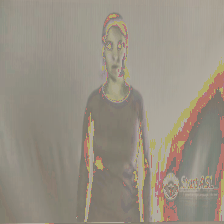

In [ ]:
import imageio
import numpy as np
from IPython.display import Image
mean = image_processor.image_mean
std = image_processor.image_std
def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""

    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)


video_tensor = eval_data[138][0]
print(label2id[id2label[eval_data[138][1]]])

display_gif(video_tensor)

In [ ]:
!pip install torch -U
!pip install --upgrade torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.0.0
    Uninstalling triton-2.0.0:
      Successfully uninstalled triton-2.0.0
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.2+cu118 requires torch==2.0.1, but you have torch 2.3.0 which is incompatible.
xformers 0.0.21 requires torch==2.0.1, but you have torch 2.3.0 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.1 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [ ]:
model.classifier = torch.nn.Linear(model.config.hidden_size, 100)


In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()
!nvidia-smi -q -d MEMORY

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
def train_auto(model, args, train_dataset,eval_dataset,image_processor, metrics, collate):
  trainer = Trainer(
      model,
      args,
      train_dataset=train_dataset,
      eval_dataset=eval_dataset,
      tokenizer=image_processor,
      compute_metrics=compute_metrics,
      data_collator=collate_fn,
  )
  trainer.train()
  log_history = trainer.state.log_history
  trainer.save_model("VideoMAEModel")
  print(log_history)
train_auto(model, args, train_data, eval_data, image_processor,compute_metrics,collate_fn  )


In [ ]:
my_trained = VideoMAEForVideoClassification.from_pretrained("VideoMAEModel")
my_trained(input video)

Manual trainer

In [ ]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification, VideoMAEFeatureExtractor
import numpy as np
import torch



# Load model directly
from transformers import AutoImageProcessor, AutoModelForVideoClassification

processor = AutoImageProcessor.from_pretrained("younggi/videomae-base-finetuned-ucf101-subset")
model = AutoModelForVideoClassification.from_pretrained("younggi/videomae-base-finetuned-ucf101-subset")
feature_extractor = VideoMAEFeatureExtractor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")

inputs = processor(video, return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)
  logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])


preprocessor_config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/videomae/feature_extraction_videomae.py:28: FutureWarning: The class VideoMAEFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use VideoMAEImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/22.1k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

NameError: name 'video' is not defined

In [ ]:
def train(model, dataloader, epochs, optimizer, loss_fn):
  for idx, (batch, labels) in enumerate(dataloader):
    batch= batch
    labels = labels
    print(batch.shape, labels.shape)
    for vid, lab in zip(batch, labels):
      inputs = feature_extractor(list(vid), return_tensors="pt")
      output = model(**inputs).logits
      label_pred = torch.argmax(output)
      optimizer.zero_grad()
      print(output, lab)
      loss = loss_fn(output, lab)
      loss.backward()
      optimizer.step()

    print("Epoch: ", epoch, " Loss: ", loss)
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
train(model, train_dataloader, 5, optimizer,loss_fn)

torch.Size([8, 16, 3, 224, 224]) torch.Size([8])
tensor([[-0.2723,  0.6765, -2.5458, -3.3786, -0.5455,  2.6371,  0.8047, -4.2952,
         -1.7919, -2.4777, -0.6924, -3.2185,  0.3028, -3.0364, -0.9742, -1.6408,
          0.9721, -2.8279, -1.2032,  0.0562, -1.7648, -1.5972, -1.3885, -1.1976,
         -0.7429, -3.9145,  0.1076, -2.7190, -2.7671, -0.8950, -1.1697, -1.0651,
         -0.4092, -3.0618, -0.0317,  0.2658, -2.7273, -1.1259, -3.9726, -1.0032,
          1.5486, -2.3433, -2.1758, -0.8310, -0.2725, -2.5822, -0.0208, -2.7411,
         -0.9355, -1.4568, -3.3844, -3.1101, -2.9256, -3.8179, -5.3948, -2.1624,
          1.1334, -3.3606, -0.4951,  0.7033, -2.6343, -1.0846, -3.3426, -3.2627,
         -1.4391, -0.4917,  1.2619, -2.6547,  0.6339,  2.7458, -3.1406, -2.2818,
         -3.2669, -2.3473, -0.5108, -0.7354,  0.5810, -1.1233, -3.1244, -0.5474,
          0.0419, -2.5725, -3.7177, -2.1447,  1.1869, -1.9053, -2.8691, -1.2448,
          0.3761, -4.9859, -1.6226, -3.2658, -0.0713,  1.103

ValueError: Expected input batch_size (1) to match target batch_size (0).